# **Cinderella Story: Predicting Football Upsets with Advanced Feature Engineering**

## **Project Overview**

This notebook presents an end-to-end machine learning pipeline designed to predict "Cinderella" upsets in football matches—where a significant underdog defies the odds to win. The project moves beyond simple win/loss prediction to identify the specific conditions that enable these surprising results.

The core methodology involves:

1.  **Rigorous Data Preparation**: Cleaning and validating raw match data, with a strict focus on preventing data leakage by using time-based splits and careful feature calculation.

2.  **Advanced Feature Engineering**: Creating a rich set of dynamic features that capture team dynamics, including:
    *   **Momentum & Form**: Short-term vs. long-term performance trends.
    *   **Fatigue & Congestion**: Rest days and match density.
    *   **Tactical Signals**: Rolling averages of shots, corners, and fouls.
    *   **Head-to-Head (H2H)**: Historical performance between the two specific teams.

3.  **Comparative Modeling**: Training and evaluating multiple feature sets (Home/Away, Underdog/Favorite, and Difference-based) to identify the most predictive combination.

4.  **Model Interpretation with SHAP**: Moving beyond "what" the model predicts to "why," using SHAP to uncover the key drivers behind upset predictions.

5.  **Impact Analysis**: Demonstrating the value of feature engineering by comparing the final model's performance against a baseline model trained on raw, unprocessed data.

---
# **Part 0: Setup**

## **0.1 Library Imports**

In [3]:
# Data manipulation
import pandas as pd
import numpy as np
import os
from datetime import timedelta 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)
from sklearn.utils import resample
from datetime import timedelta

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import shap

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## **0.2 Constants and Configuration**

In [4]:
# FILE PATHS
RAW_DATA_PATH = "Matches.csv"
PROCESSED_DATA_PATH = "Matches_Prepared.csv"

# DATA FILTERING
TOP_LEAGUES = ['E0', 'SP1', 'D1', 'I1', 'F1']  # Premier League, La Liga, Bundesliga, Serie A, Ligue 1

# FEATURE ENGINEERING PARAMETERS
HOME_ADVANTAGE = 100  # Elo points added to home team
PROB_THRESHOLD = 0.3  # Maximum underdog win probability to classify as "cinderella"
ROLLING_WINDOWS = [3, 5]  # Window sizes for rolling statistics

# FEATURE  OPTIONS
USE_HOME_AWAY = True
USE_UNDERDOG_FAV = False
USE_DIFFERENCE = False

# Seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# UPDATE PROCESSED FILE
UPDATE_PROCESSED_FILE = True

# RUN CODE
RUN_CODE = True

## **0.3 Data Loading**

In [5]:
def load_data(path):
    """
    Load raw match data.
    """
    print(f"📂 Loading data from: {path}")
    df = pd.read_csv(path)
    print(f"   Initial shape: {df.shape}")

    return df

In [6]:
if RUN_CODE:
    # Load data
    df_original = load_data(RAW_DATA_PATH)

    print("\n📋 Dataset Preview:")
    print(df_original.head())

📂 Loading data from: Matches.csv
   Initial shape: (230557, 48)

📋 Dataset Preview:
  Division   MatchDate MatchTime   HomeTeam    AwayTeam   HomeElo   AwayElo  Form3Home  Form5Home  Form3Away  Form5Away  FTHome  FTAway FTResult  HTHome  HTAway HTResult  HomeShots  AwayShots  HomeTarget  AwayTarget  HomeFouls  AwayFouls  HomeCorners  AwayCorners  HomeYellow  AwayYellow  HomeRed  AwayRed  OddHome  OddDraw  OddAway  MaxHome  MaxDraw  MaxAway  Over25  Under25  MaxOver25  MaxUnder25  HandiSize  HandiHome  HandiAway  C_LTH  C_LTA  C_VHD  C_VAD  C_HTB  C_PHB
0       F1  2000-07-28       NaN  Marseille      Troyes 1686.3400 1586.5700     0.0000     0.0000     0.0000     0.0000  3.0000  1.0000        H  2.0000  1.0000        H        NaN        NaN         NaN         NaN        NaN        NaN          NaN          NaN         NaN         NaN      NaN      NaN   1.6500   3.3000   4.3000      NaN      NaN      NaN     NaN      NaN        NaN         NaN        NaN        NaN        NaN    NaN  

In [7]:
if RUN_CODE:
    print("📊 Data info:")
    df_original.info()

📊 Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230557 entries, 0 to 230556
Data columns (total 48 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Division     230557 non-null  object 
 1   MatchDate    230557 non-null  object 
 2   MatchTime    99072 non-null   object 
 3   HomeTeam     230557 non-null  object 
 4   AwayTeam     230557 non-null  object 
 5   HomeElo      141597 non-null  float64
 6   AwayElo      141528 non-null  float64
 7   Form3Home    229057 non-null  float64
 8   Form5Home    229057 non-null  float64
 9   Form3Away    229057 non-null  float64
 10  Form5Away    229057 non-null  float64
 11  FTHome       230554 non-null  float64
 12  FTAway       230554 non-null  float64
 13  FTResult     230554 non-null  object 
 14  HTHome       175977 non-null  float64
 15  HTAway       175977 non-null  float64
 16  HTResult     175977 non-null  object 
 17  HomeShots    114735 non-null  float64
 18  AwayShots  

---
# **Part 1: Initial Cleaning**

## **1.1 Filtering available data**

Since the target is to predict ... -> we can only use historical or pre-match data: (focus on 5 big league)

- `Division`
- `MatchDate`
- `MatchTime`
- `HomeTeam`
- `AwayTeam`
- `HomeElo`
- `AwayElo`
- `Form3Home`
- `Form5Home`
- `Form3Away`
- `Form5Away`

and some other columns for further feature engineering:

- `FTHome`
- `FTAway`
- `FTResult`
- `HomeShots`
- `AwayShots`
- `HomeTarget`
- `AwayTarget`
- `HomeCorners`
- `AwayCorners`
- `HomeFouls`
- `AwayFouls`
- `HomeYellow`
- `AwayYellow`
- `HomeRed`
- `AwayRed`

In [8]:
def filter_data(df):
    """
    Filter and select relevant columns for analysis.
    """
    print(f"Step 1.1 Filtering data:")
    
    # Filter for top leagues only
    df = df[df['Division'].isin(TOP_LEAGUES)].copy()

    # Define relevant columns
    relevant_columns = [
        'Division', 'MatchDate', 'MatchTime', 'HomeTeam', 'AwayTeam', 'HomeElo', 'AwayElo', 
        'Form3Home', 'Form3Away', 'Form5Home', 'Form5Away',
        'FTHome', 'FTAway', 'FTResult',
        'HomeShots', 'AwayShots', 'HomeTarget', 'AwayTarget',
        'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
        'HomeYellow', 'AwayYellow', 'HomeRed', 'AwayRed'
    ]
    
    # Filter columns
    df_filtered = df[relevant_columns].copy()
    print(f"   After filtering relevant columns: {df_filtered.shape}")

    return df_filtered

In [9]:
if RUN_CODE:
    df_prepared = filter_data(df_original)
    print("Filter completed. Preview of prepared data:")
    print(df_prepared.head())

Step 1.1 Filtering data:
   After filtering relevant columns: (43708, 26)
Filter completed. Preview of prepared data:
  Division   MatchDate MatchTime   HomeTeam    AwayTeam   HomeElo   AwayElo  Form3Home  Form3Away  Form5Home  Form5Away  FTHome  FTAway FTResult  HomeShots  AwayShots  HomeTarget  AwayTarget  HomeCorners  AwayCorners  HomeFouls  AwayFouls  HomeYellow  AwayYellow  HomeRed  AwayRed
0       F1  2000-07-28       NaN  Marseille      Troyes 1686.3400 1586.5700     0.0000     0.0000     0.0000     0.0000  3.0000  1.0000        H        NaN        NaN         NaN         NaN          NaN          NaN        NaN        NaN         NaN         NaN      NaN      NaN
1       F1  2000-07-28       NaN   Paris SG  Strasbourg 1714.8900 1642.5100     0.0000     0.0000     0.0000     0.0000  3.0000  1.0000        H        NaN        NaN         NaN         NaN          NaN          NaN        NaN        NaN         NaN         NaN      NaN      NaN
3       F1  2000-07-29       NaN    Aux

In [10]:
if RUN_CODE:
    # Check missing values
    print("\n📉 Missing Values Percentage per Column:")
    df_prepared.isnull().mean().sort_values(ascending=False)


📉 Missing Values Percentage per Column:


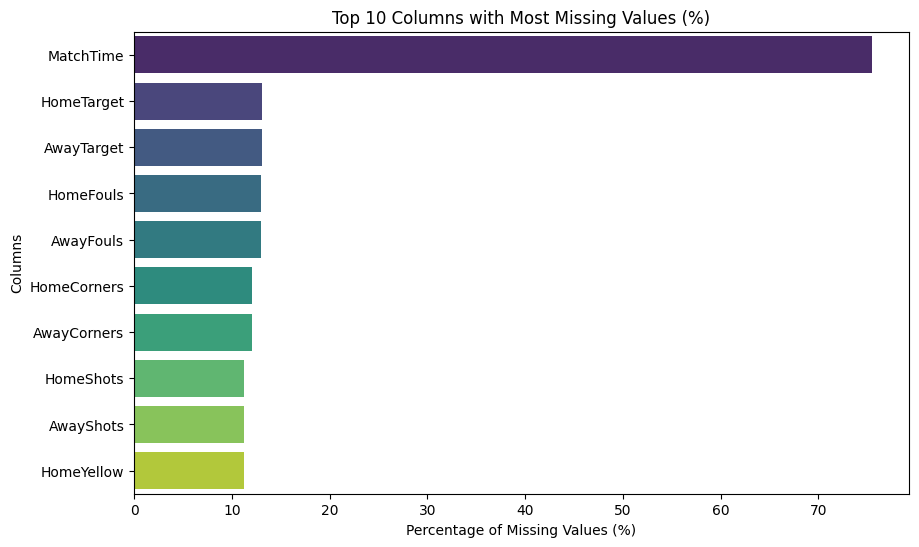

In [11]:
if RUN_CODE:
    # bar chart for top 10 columns with most missing values
    missing_percent = df_prepared.isnull().mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_percent.values * 100, y=missing_percent.index, palette="viridis")
    plt.title("Top 10 Columns with Most Missing Values (%)")
    plt.xlabel("Percentage of Missing Values (%)")
    plt.ylabel("Columns")
    plt.show()

#### **Insights from the `missingno` Matrix**

The matrix plot reveals a clear structure to the missing data:

*   **`MatchTime` Column:**
    *   **Observation:** This column is almost entirely white, indicating a severe lack of data.
    *   **Decision:** This is considered noise, not a useful signal. It will be **dropped** immediately to simplify the dataset.

*   **Match Statistics Columns (`HomeShots`, `AwayShots`, `Corners`, etc.):**
    *   **Observation:** There are distinct horizontal white bands concentrated at the top of the plot.
    *   **Insight:** Historical football data, especially from the early years (e.g., 2000-2010), often lacks detailed statistics like shots and corners. The data becomes more complete (denser black lines) in more recent years (the bottom of the plot).
    *   **Implication:** Features that rely on these stats (like a Game Dominance Index or fatigue metrics) cannot be calculated for older matches. Keeping these rows without imputation would make the model "blind" to these important factors.

## **1.2 Data Cleaning**

In [12]:
def clean_data(df):
    """
    Clean and preprocess the data.
    """
    print("Step 1.2 Cleaning data")

    # Convert MatchDate to datetime
    df['MatchDate'] = pd.to_datetime(df['MatchDate'], dayfirst=True, errors='coerce')
    print("   Converted MatchDate to datetime.")
    
    # Sort by date
    df = df.sort_values(by='MatchDate').reset_index(drop=True)
    print("   Sorted data by MatchDate.")
    
    # Drop MatchTime as missing values are high
    if 'MatchTime' in df.columns:
        df = df.drop(columns=['MatchTime'])
        print("   Dropped MatchTime column.")

    # remove invalid rows
    initial_len = len(df)
    
    condition_valid_score = (df['FTHome'] >= 0) & (df['FTAway'] >= 0)
    condition_valid_elo = (df['HomeElo'] > 0) & (df['AwayElo'] > 0)
    
    df = df[condition_valid_score & condition_valid_elo].copy()
    
    print(f"   Removed {initial_len - len(df)} rows with invalid scores/Elo.")

    # remove Duplicates
    before_dedup = len(df)
    df = df.drop_duplicates()
    if len(df) < before_dedup:
        print(f"   Removed {before_dedup - len(df)} duplicate rows.")


    return df

In [13]:
if RUN_CODE:
    df_prepared = clean_data(df_prepared)
    print("Cleaning completed")

Step 1.2 Cleaning data
   Converted MatchDate to datetime.
   Sorted data by MatchDate.
   Dropped MatchTime column.
   Removed 40 rows with invalid scores/Elo.
Cleaning completed


## **1.3 Check Outliers and Invalid Data**

In [14]:
def plot_dist(df):
    """
    Plot distribution for outliers check.
    """
    # pick important numeric columns
    numeric_cols = ['HomeElo', 'AwayElo', 'HomeShots', 'AwayShots', 'FTHome', 'FTAway', 'HomeTarget', 'AwayTarget']
    
    # Set up the plot grid
    fig, axes = plt.subplots(2, 4, figsize=(18, 10))
    fig.suptitle('Distribution of Key Metrics: Identifying Outliers vs. Natural Variance', fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    for i, col in enumerate(numeric_cols):
        if col in df.columns:
            sns.histplot(df[col], kde=True, ax=axes[i], color='#4c72b0', bins=30)
            
            axes[i].set_title(f'{col} Distribution', fontweight='bold')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            

    plt.grid(False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92) 
    plt.show()

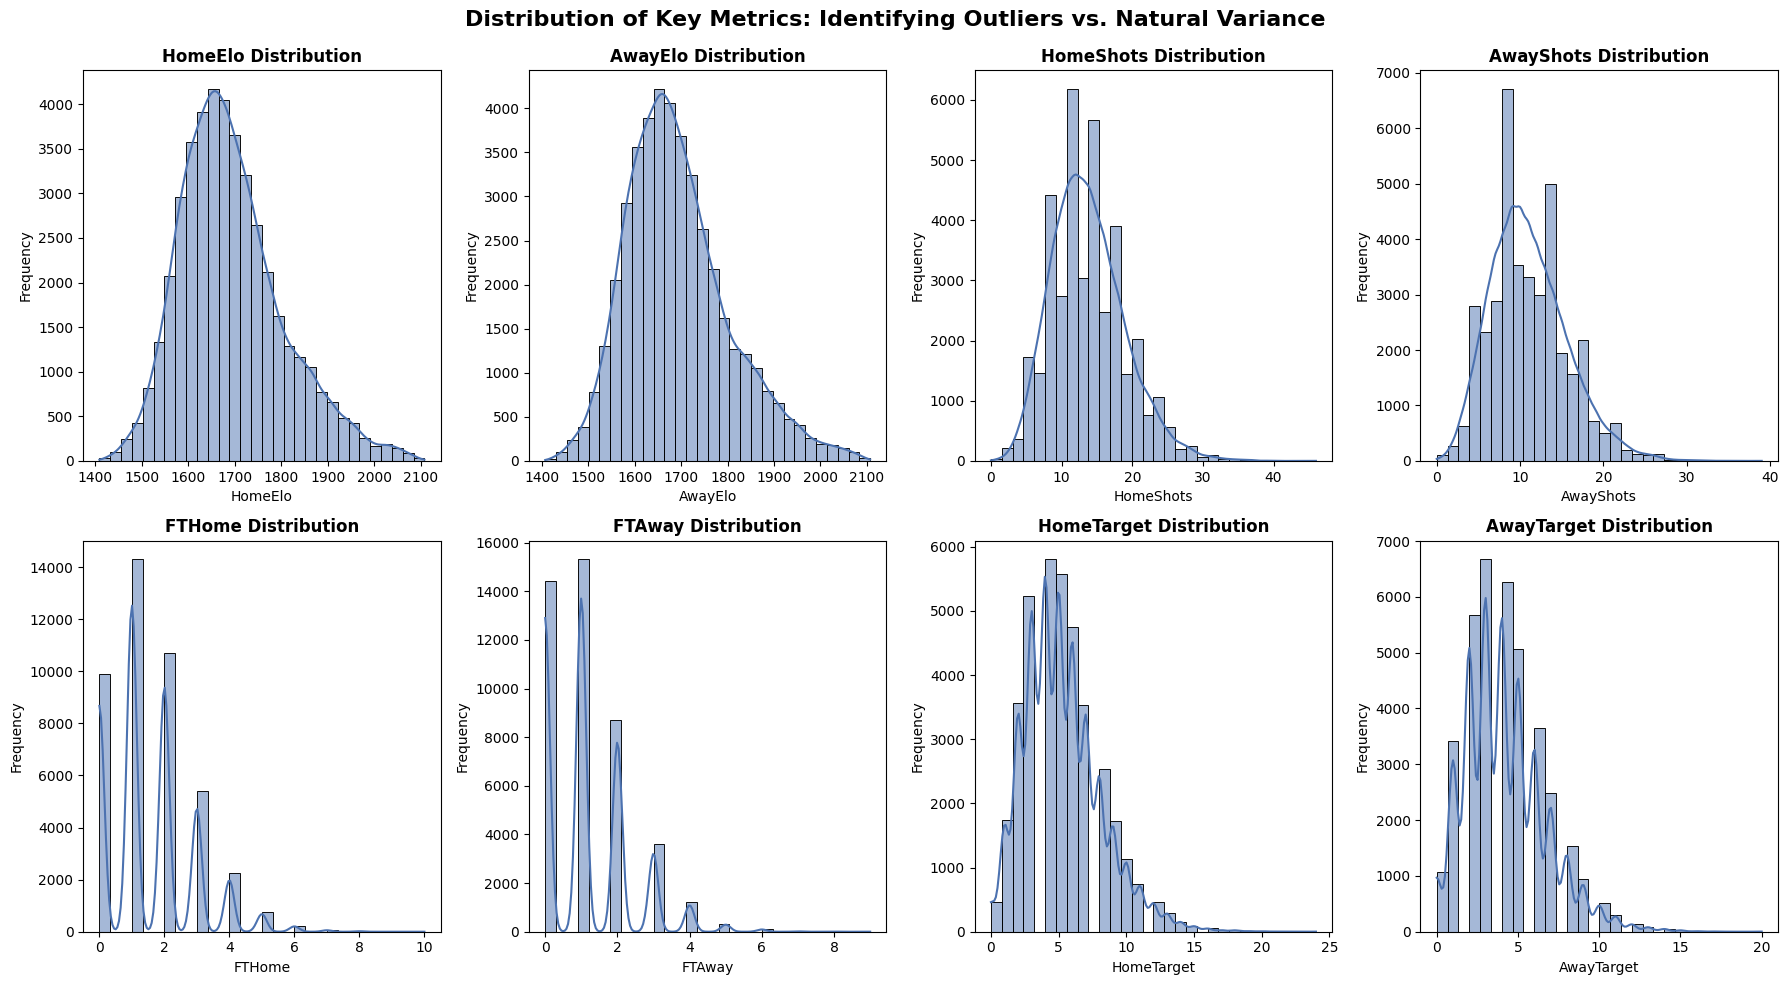

In [15]:
if RUN_CODE:
    plot_dist(df_prepared)

#### **Insights from Distribution Plots: Signal vs. Noise**

*   **Elo Distribution:**
    *   **Observation:** The distribution is a clean, classic bell curve, with most values concentrated between 1400-1800.
    *   **Insight:** Values beyond the 99th percentile (around 2000+) are not errors. These represent the "Goliaths" of football (e.g., Real Madrid, Man City, Bayern).
    *   **Decision:** Removing these 'outliers' would eliminate the antagonists of our Cinderella story. There can be no upset without a giant to defeat. Therefore, we **keep these values**.

*   **Shots & Targets Distribution:**
    *   **Observation:** The distribution is heavily right-skewed with a long tail. Some matches have an extreme number of shots (30-40).
    *   **Insight:** A match where a team has 30 shots but fails to win is the classic Cinderella narrative. For example, Celtic famously beat Barcelona 2-1 despite having only 11% possession. These extreme values are the story.
    *   **Decision:** This is a crucial **signal**, not noise. We **keep these values** as they are essential for identifying potential upsets.


---
# **Part 2: Target Variable**

## **2.1 Create Target feature**

In [16]:
def create_target_feature(df, home_advantage=HOME_ADVANTAGE, prob_threshold=PROB_THRESHOLD):
    """
     Create target feature 'is_cinderella' based on underdog wins with low probability.
    """
    print(" Step 2.1: Creating Target Feature")
    df['Elo_diff'] = (df['HomeElo'] + home_advantage - df['AwayElo'])
    df['Prob_HomeWin'] = 1 / (1 + 10 ** (-df['Elo_diff'] / 400))
    df['Prob_AwayWin'] = 1 - df['Prob_HomeWin']

    # Determine favorite and underdog based on probability
    df['favorite'] = np.where(df['Prob_HomeWin'] >= 0.5, 'Home', 'Away')
    df['underdog'] = np.where(df['favorite'] == 'Home', 'Away', 'Home')

    # Get the underdog's win probability
    df['Prob_UnderdogWin'] = np.where(df['underdog'] == 'Home', df['Prob_HomeWin'], df['Prob_AwayWin'])

    # Determine if the result is a cinderella win
    underdog_wins = (
        ((df['underdog'] == 'Home') & (df['FTResult'] == 'H')) |
        ((df['underdog'] == 'Away') & (df['FTResult'] == 'A'))
    )
    is_low_prob = (df['Prob_UnderdogWin'] < prob_threshold)
    df['is_cinderella'] = (underdog_wins & is_low_prob).astype(int)
    df['Elo_diff'] = df['Elo_diff'] - home_advantage
    print("   ✓ Target feature 'is_cinderella' created.")
    
    return df

In [17]:
if RUN_CODE:
    df_prepared = create_target_feature(df_prepared)
    print(f'  Cinderella rate: {df_prepared["is_cinderella"].mean() * 100:.2f}%')

 Step 2.1: Creating Target Feature
   ✓ Target feature 'is_cinderella' created.
  Cinderella rate: 5.81%


---
# **Part 3: Advanced Feature Engineering**

## **Critical Note on Data Leakage Prevention**
All rolling calculations use `.shift(1)` before `.rolling()` to ensure we only use information available **before** each match.

## **3.1 Helper function for feature creation**

In [18]:
def count_matches_in_window(g, days=10):
    g = g.sort_values('MatchDate').copy()
    counts = []
    for idx in g.index:
        current_date = g.at[idx, 'MatchDate']
        window_start = current_date - pd.Timedelta(days=days)
        matches_before = g[(g['MatchDate'] >= window_start) & (g['MatchDate'] < current_date)]
        counts.append(len(matches_before))
    return pd.Series(counts, index=g.index)

## **3.2 Feature Engineering**

In [19]:
# creating new features with no leakage
def feature_engineering(df):
    print("\n Starting feature engineering...")

    df = df.sort_values('MatchDate').reset_index(drop=True)
    df['_match_id'] = np.arange(len(df))

    # ===================================================================
    # === A. Home/Away Features ===
    # ===================================================================

    print(" A. Creating Home/Away Features...")

    # ===================================================================
    # === 1. Rest Days and Congestion ===
    # ===================================================================

    # Number of days since last match for home and away teams
    # and congestion in last 10 days (number of matches played in last 10 days)
    print("   1.1. Calculating Rest Days...")
    team_dates_home = df[['_match_id', 'MatchDate', 'HomeTeam']].copy()
    team_dates_home.columns = ['_match_id', 'MatchDate', 'team']
    team_dates_home['is_home'] = 1

    team_dates_away = df[['_match_id', 'MatchDate', 'AwayTeam']].copy()
    team_dates_away.columns = ['_match_id', 'MatchDate', 'team']
    team_dates_away['is_home'] = 0

    team_dates = pd.concat([team_dates_home, team_dates_away], ignore_index=True)
    team_dates = team_dates.sort_values(['team', 'MatchDate']).reset_index(drop=True)
    team_dates['last_match_date'] = team_dates.groupby('team')['MatchDate'].shift(1)
    team_dates['rest_days'] = (team_dates['MatchDate'] - team_dates['last_match_date']).dt.days

    home_rest = team_dates[team_dates['is_home'] == 1].set_index('_match_id')['rest_days']
    away_rest = team_dates[team_dates['is_home'] == 0].set_index('_match_id')['rest_days']

    df['RestDaysHome'] = df['_match_id'].map(home_rest)
    df['RestDaysAway'] = df['_match_id'].map(away_rest)
    print("      ✓ Rest Days calculated.")

    print("   1.2. Calculating Congestion (matches in last 10 days)...")
    team_dates_home = df[['_match_id', 'MatchDate', 'HomeTeam']].copy()
    team_dates_home.columns = ['_match_id', 'MatchDate', 'team']
    team_dates_home['is_home'] = 1
    
    team_dates_away = df[['_match_id', 'MatchDate', 'AwayTeam']].copy()
    team_dates_away.columns = ['_match_id', 'MatchDate', 'team']
    team_dates_away['is_home'] = 0
    
    team_dates = pd.concat([team_dates_home, team_dates_away], ignore_index=True)
    team_dates = team_dates.sort_values(['team', 'MatchDate']).reset_index(drop=True)
    
    team_dates['congestion_10d'] = team_dates.groupby('team', group_keys=False).apply(
        lambda g: count_matches_in_window(g, 10)
    )
    home_congestion = team_dates[team_dates['is_home'] == 1].set_index('_match_id')['congestion_10d']
    away_congestion = team_dates[team_dates['is_home'] == 0].set_index('_match_id')['congestion_10d']
    
    df['CongestionHome_10d'] = df['_match_id'].map(home_congestion)
    df['CongestionAway_10d'] = df['_match_id'].map(away_congestion)
    print("      ✓ Congestion calculated.")


    # ===================================================================
    # === 2. Elo changes ===
    # ===================================================================

    # Calcuate Elo changes over past 1 month and 2 months for home and away teams
    print("   2. Calculating Elo Changes (1 month & 2 months)...")
    home_elo_data = df[['MatchDate', 'HomeTeam', 'HomeElo', '_match_id']].copy()
    home_elo_data.columns = ['MatchDate', 'team', 'elo', '_match_id']
    home_elo_data['is_home'] = 1

    away_elo_data = df[['MatchDate', 'AwayTeam', 'AwayElo', '_match_id']].copy()
    away_elo_data.columns = ['MatchDate', 'team', 'elo', '_match_id']
    away_elo_data['is_home'] = 0

    team_elo = pd.concat([home_elo_data, away_elo_data], ignore_index=True)
    team_elo = team_elo.sort_values(['team', 'MatchDate']).reset_index(drop=True)

    team_elo['MatchDate_ref_1m'] = team_elo['MatchDate'] - pd.Timedelta(days=30)
    team_elo['MatchDate_ref_2m'] = team_elo['MatchDate'] - pd.Timedelta(days=60)

    right_df_sorted = team_elo[['team', 'MatchDate', 'elo']].rename(columns={'elo': 'past_elo'}).sort_values('MatchDate')

    merged_1m = pd.merge_asof(
        team_elo.sort_values('MatchDate_ref_1m'), # Sắp xếp theo cột bên trái
        right_df_sorted,
        left_on='MatchDate_ref_1m',
        right_on='MatchDate',
        by='team',
        direction='backward' # Tìm giá trị gần nhất TRƯỚC ngày tham chiếu
    )
    merged_1m['EloChange1'] = merged_1m['elo'] - merged_1m['past_elo']

    merged_2m = pd.merge_asof(
        team_elo.sort_values('MatchDate_ref_2m'),
        right_df_sorted,
        left_on='MatchDate_ref_2m',
        right_on='MatchDate',
        by='team',
        direction='backward'
    )
    merged_2m['EloChange2'] = merged_2m['elo'] - merged_2m['past_elo']

    team_elo_indexed = team_elo.set_index(['_match_id', 'team'])

    # Set index cho các kết quả merge để join
    merged_1m = merged_1m.set_index(['_match_id', 'team'])
    merged_2m = merged_2m.set_index(['_match_id', 'team'])

    # Join các kết quả
    team_elo_indexed['EloChange1'] = merged_1m['EloChange1']
    team_elo_indexed['EloChange2'] = merged_2m['EloChange2']

    # Reset index 
    final_elo_changes = team_elo_indexed.reset_index()

    # Tách home/away và merge về df gốc
    home_changes = final_elo_changes[final_elo_changes['is_home'] == 1][['_match_id', 'EloChange1', 'EloChange2']].rename(
        columns={'EloChange1': 'EloChange1Home', 'EloChange2': 'EloChange2Home'})
    away_changes = final_elo_changes[final_elo_changes['is_home'] == 0][['_match_id', 'EloChange1', 'EloChange2']].rename(
        columns={'EloChange1': 'EloChange1Away', 'EloChange2': 'EloChange2Away'})

    df = df.merge(home_changes, on='_match_id', how='left')
    df = df.merge(away_changes, on='_match_id', how='left')

    print("      ✓ Elo Changes calculated.")

    # ===================================================================
    # === 3. Rolling Stats ===
    # ===================================================================

    print("   3. Calculating Rolling Stats...")
    # Prepare data for rolling stats calculation
    home_base = df[['_match_id', 'MatchDate', 'HomeTeam', 'FTHome', 'FTAway']].rename(
        columns={'HomeTeam': 'team', 'FTHome': 'GoalsFor', 'FTAway': 'GoalsAgainst'}
    )
    home_base['is_home'] = 1

    away_base = df[['_match_id', 'MatchDate', 'AwayTeam', 'FTAway', 'FTHome']].rename(
        columns={'AwayTeam': 'team', 'FTAway': 'GoalsFor', 'FTHome': 'GoalsAgainst'}
    )
    away_base['is_home'] = 0

    team_stats = pd.concat([home_base, away_base])
    team_stats['points'] = np.where(
        team_stats['GoalsFor'] > team_stats['GoalsAgainst'], 3,
        np.where(team_stats['GoalsFor'] == team_stats['GoalsAgainst'], 1, 0)
    )

    advanced_stats_map = {
        'HomeShots': 'shots', 'AwayShots': 'shots',
        'HomeTarget': 'target', 'AwayTarget': 'target',
        'HomeCorners': 'corners', 'AwayCorners': 'corners',
        'HomeFouls': 'fouls', 'AwayFouls': 'fouls',
        'HomeYellow': 'yellow', 'AwayYellow': 'yellow',
        'HomeRed': 'red', 'AwayRed': 'red'
    }

    existing_adv_cols = [col for col in advanced_stats_map.keys() if col in df.columns]
    if existing_adv_cols:
        advanced_df = df[['_match_id'] + existing_adv_cols].copy()

        for stat_name in set(advanced_stats_map.values()):
            home_col = next((k for k, v in advanced_stats_map.items() if v == stat_name and 'Home' in k), None)
            away_col = next((k for k, v in advanced_stats_map.items() if v == stat_name and 'Away' in k), None)
            if home_col and away_col and home_col in advanced_df.columns and away_col in advanced_df.columns:
                advanced_df[f'{stat_name}_total'] = advanced_df[home_col] + advanced_df[away_col]

        team_stats = team_stats.merge(advanced_df, on='_match_id', how='left')

        for stat_name in set(advanced_stats_map.values()):
            home_col = next((k for k, v in advanced_stats_map.items() if v == stat_name and 'Home' in k), None)
            away_col = next((k for k, v in advanced_stats_map.items() if v == stat_name and 'Away' in k), None)
            if home_col and away_col and home_col in team_stats.columns and away_col in team_stats.columns:
                team_stats[f'{stat_name}_for'] = np.where(team_stats['is_home'] == 1, team_stats[home_col], team_stats[away_col])
                team_stats[f'{stat_name}_conceded'] = team_stats[f'{stat_name}_total'] - team_stats[f'{stat_name}_for']

    team_stats = team_stats.sort_values(['team', 'MatchDate']).reset_index(drop=True)

    # === 3.1. Basic Rolling Stats ===
    print("      3.1. Basic Rolling Stats (Forms, Goals For/Against)...")
    basic_cols_to_shift = ['GoalsFor', 'GoalsAgainst', 'points']
    for col in basic_cols_to_shift:
        team_stats[f'{col}_shifted'] = team_stats.groupby('team')[col].shift(1)

    for w in [3, 5]:
        team_stats[f'GF{w}'] = team_stats.groupby('team')['GoalsFor_shifted'].rolling(w, min_periods=0).sum().reset_index(level=0, drop=True)
        team_stats[f'GA{w}'] = team_stats.groupby('team')['GoalsAgainst_shifted'].rolling(w, min_periods=0).sum().reset_index(level=0, drop=True)
        team_stats[f'Form{w}'] = team_stats.groupby('team')['points_shifted'].rolling(w, min_periods=0).sum().reset_index(level=0, drop=True)
    print("          ✓ Basic Rolling Stats calculated.")

    # === 3.2. Advanced Rolling Stats ===
    print("      3.2. Advanced Rolling Stats (Shots, Target, Corners, Fouls, Yellow, Red)...")
    advanced_cols_to_shift = [c for c in team_stats.columns if '_for' in c or '_conceded' in c]
    for col in advanced_cols_to_shift:
        team_stats[f'{col}_shifted'] = team_stats.groupby('team')[col].shift(1)

    agg_dict = {}
    stat_types = ['shots', 'target', 'corners', 'fouls', 'yellow', 'red']
    for stat in stat_types:
        for_col_shifted = f'{stat}_for_shifted'
        conceded_col_shifted = f'{stat}_conceded_shifted'
        
        if for_col_shifted in team_stats.columns:
            for w in [3, 5]:
                team_stats[f'{stat.capitalize()}{w}'] = team_stats.groupby('team')[for_col_shifted].rolling(w, min_periods=0).sum().reset_index(level=0, drop=True)

        if conceded_col_shifted in team_stats.columns:
            for w in [3, 5]:
                team_stats[f'{stat.capitalize()}Conceded{w}'] = team_stats.groupby('team')[conceded_col_shifted].rolling(w, min_periods=0).sum().reset_index(level=0, drop=True)

    print("          ✓ Advanced Rolling Stats calculated.")

    # Merge rolling stats back to main dataframe
    home_final = team_stats[team_stats['is_home'] == 1].add_prefix('Home')
    away_final = team_stats[team_stats['is_home'] == 0].add_prefix('Away')

    df = df.merge(home_final, left_on=['_match_id'], right_on=['Home_match_id'], how='left')
    df = df.merge(away_final, left_on=['_match_id'], right_on=['Away_match_id'], how='left')

    # ===================================================================
    # === 4. Head-to-Head Features ===
    # ===================================================================

    # The number of wins and points in last 3 and 5 matches between the two teams
    print("   4. Calculating Head-to-Head Features...")
    df['team_pair'] = df.apply(lambda row: tuple(sorted([row['HomeTeam'], row['AwayTeam']])), axis=1)
    df = df.sort_values(['team_pair', 'MatchDate'])

    # calculate points and wins for home and away teams
    df['HomePoints'] = np.where(df['FTHome'] > df['FTAway'], 3, np.where(df['FTHome'] == df['FTAway'], 1, 0))
    df['AwayPoints'] = np.where(df['FTAway'] > df['FTHome'], 3, np.where(df['FTAway'] == df['FTHome'], 1, 0))
    df['HomeWin'] = np.where(df['FTHome'] > df['FTAway'], 1, 0)
    df['AwayWin'] = np.where(df['FTAway'] > df['FTHome'], 1, 0)

    grouped = df.groupby('team_pair')
    df['prev_home_pts'] = grouped['HomePoints'].shift(1)
    df['prev_away_pts'] = grouped['AwayPoints'].shift(1)
    df['prev_home_wins'] = grouped['HomeWin'].shift(1)
    df['prev_away_wins'] = grouped['AwayWin'].shift(1)
    df['prev_home'] = grouped['HomeTeam'].shift(1)

    # group_shifted = df.groupby('team_pair')
    for w in [3, 5]:
        df[f'h2h_Home_Points{w}'] = df.groupby('team_pair')['prev_home_pts'].rolling(window=w, min_periods=1).sum().reset_index(level=0, drop=True)
        df[f'h2h_Away_Points{w}'] = df.groupby('team_pair')['prev_away_pts'].rolling(window=w, min_periods=1).sum().reset_index(level=0, drop=True)
        df[f'h2h_Home_Wins{w}'] = df.groupby('team_pair')['prev_home_wins'].rolling(window=w, min_periods=1).sum().reset_index(level=0, drop=True)
        df[f'h2h_Away_Wins{w}'] = df.groupby('team_pair')['prev_away_wins'].rolling(window=w, min_periods=1).sum().reset_index(level=0, drop=True)

    for w in [3, 5]:
        is_home_team_A = df['HomeTeam'] == df['team_pair'].str[0]
        
        df[f'H2H_Home_Points{w}'] = np.where(is_home_team_A, df[f'h2h_Home_Points{w}'], df[f'h2h_Away_Points{w}'])
        df[f'H2H_Away_Points{w}'] = np.where(is_home_team_A, df[f'h2h_Away_Points{w}'], df[f'h2h_Home_Points{w}'])
        df[f'H2H_Home_Wins{w}'] = np.where(is_home_team_A, df[f'h2h_Home_Wins{w}'], df[f'h2h_Away_Wins{w}'])
        df[f'H2H_Away_Wins{w}'] = np.where(is_home_team_A, df[f'h2h_Away_Wins{w}'], df[f'h2h_Home_Wins{w}'])
   
    # fill NaN with 0 (created by shift)
    h2h_cols = [c for c in df.columns if c.startswith('H2H_')]
    # df[h2h_cols] = df[h2h_cols].fillna(0)

    df = df.sort_values('MatchDate').reset_index(drop=True)
    print("      ✓ Head-to-Head Features calculated.")

    # ===================================================================
    # === 5. Momentum Features ===
    # ===================================================================

    # The difference between short-term and long-term form (3-match form minus 5-match form)
    print("   5. Calculating Momentum Features...")
    df['MomentumHome'] = (df['Form3Home'] / 3) - (df['Form5Home'] / 5)
    df['MomentumAway'] = (df['Form3Away'] / 3) - (df['Form5Away'] / 5)
    print("      ✓ Momentum Features calculated.")


    # ===================================================================
    # === B. Underdog/Favorite Features ===
    # ===================================================================

    print("B. Creating underdog/favorite and difference features...")
    # create boolean masks for underdog and favorite status
    is_home_underdog = (df['underdog'] == 'Home')
    is_away_underdog = (df['underdog'] == 'Away')
    is_home_favorite = (df['favorite'] == 'Home')
    is_away_favorite = (df['favorite'] == 'Away')

    # ===================================================================
    # === 1. Rest Days ===
    # ===================================================================

    print("   1. Creating Rest Days features...")
    df['RestDays_underdog'] = np.where(is_home_underdog, df['RestDaysHome'],
                                np.where(is_away_underdog, df['RestDaysAway'], np.nan))
    df['RestDays_fav'] = np.where(is_home_favorite, df['RestDaysHome'],
                            np.where(is_away_favorite, df['RestDaysAway'], np.nan))
    df['RestDays_diff'] = df['RestDays_fav'] - df['RestDays_underdog']
    print("      ✓ Rest Days features created.")

    # ===================================================================
    # === 2. Congestion ===
    # ===================================================================

    print("   2. Creating Congestion features...")
    df['Congestion_underdog_10d'] = np.where(is_home_underdog, df['CongestionHome_10d'],
                                    np.where(is_away_underdog, df['CongestionAway_10d'], np.nan))
    df['Congestion_fav_10d'] = np.where(is_home_favorite, df['CongestionHome_10d'],
                                np.where(is_away_favorite, df['CongestionAway_10d'], np.nan))
    df['Congestion_diff_10d'] = df['Congestion_fav_10d'] - df['Congestion_underdog_10d']
    print("      ✓ Congestion features created.")

    # ===================================================================
    # === 3.1. Form 3 ===
    # ===================================================================
    print("   3. Creating Form features...")
    df['Form3_underdog'] = np.where(is_home_underdog, df['Form3Home'],
                            np.where(is_away_underdog, df['Form3Away'], np.nan))
    df['Form3_fav'] = np.where(is_home_favorite, df['Form3Home'],
                        np.where(is_away_favorite, df['Form3Away'], np.nan))
    df['Form3_diff'] = df['Form3_fav'] - df['Form3_underdog']
    
    # ===================================================================
    # === 3.2. Form 5 ===
    # ===================================================================

    df['Form5_underdog'] = np.where(is_home_underdog, df['Form5Home'],
                            np.where(is_away_underdog, df['Form5Away'], np.nan))
    df['Form5_fav'] = np.where(is_home_favorite, df['Form5Home'],
                        np.where(is_away_favorite, df['Form5Away'], np.nan))
    df['Form5_diff'] = df['Form5_fav'] - df['Form5_underdog']
    print("      ✓ Form features created.")

    # ===================================================================   
    # === 4. Elo Change ===
    # ===================================================================   

    print("   4. Creating Elo Change features...")
    df['EloChange1_underdog'] = np.where(is_home_underdog, df['EloChange1Home'],
                                np.where(is_away_underdog, df['EloChange1Away'], np.nan))
    df['EloChange1_fav'] = np.where(is_home_favorite, df['EloChange1Home'],
                            np.where(is_away_favorite, df['EloChange1Away'], np.nan))
    df['EloChange1_diff'] = df['EloChange1_fav'] - df['EloChange1_underdog']

    df['EloChange2_underdog'] = np.where(is_home_underdog, df['EloChange2Home'],
                                np.where(is_away_underdog, df['EloChange2Away'], np.nan))
    df['EloChange2_fav'] = np.where(is_home_favorite, df['EloChange2Home'],
                            np.where(is_away_favorite, df['EloChange2Away'], np.nan))
    df['EloChange2_diff'] = df['EloChange2_fav'] - df['EloChange2_underdog']
    print("      ✓ Elo Change features created.")

    # ===================================================================
    # === 5. H2H ===
    # ===================================================================

    print("   5. Creating Head-to-Head features...")
    df['H2H_underdog_Wins3'] = np.where(is_home_underdog, df['H2H_Home_Wins3'],
                                np.where(is_away_underdog, df['H2H_Away_Wins3'], np.nan))
    df['H2H_fav_Wins3'] = np.where(is_home_favorite, df['H2H_Home_Wins3'],
                            np.where(is_away_favorite, df['H2H_Away_Wins3'], np.nan))
    df['H2H_Wins3_diff'] = df['H2H_fav_Wins3'] - df['H2H_underdog_Wins3']

    df['H2H_underdog_Wins5'] = np.where(is_home_underdog, df['H2H_Home_Wins5'],
                                np.where(is_away_underdog, df['H2H_Away_Wins5'], np.nan))
    df['H2H_fav_Wins5'] = np.where(is_home_favorite, df['H2H_Home_Wins5'],
                            np.where(is_away_favorite, df['H2H_Away_Wins5'], np.nan))
    df['H2H_Wins5_diff'] = df['H2H_fav_Wins5'] - df['H2H_underdog_Wins5']
    
    df['H2H_underdog_Points3'] = np.where(is_home_underdog, df['H2H_Home_Points3'],
                                np.where(is_away_underdog, df['H2H_Away_Points3'], np.nan))
    df['H2H_fav_Points3'] = np.where(is_home_favorite, df['H2H_Home_Points3'],
                            np.where(is_away_favorite, df['H2H_Away_Points3'], np.nan))
    df['H2H_Points3_diff'] = df['H2H_fav_Points3'] - df['H2H_underdog_Points3']
    
    df['H2H_underdog_Points5'] = np.where(is_home_underdog, df['H2H_Home_Points5'],
                                np.where(is_away_underdog, df['H2H_Away_Points5'], np.nan))
    df['H2H_fav_Points5'] = np.where(is_home_favorite, df['H2H_Home_Points5'],
                            np.where(is_away_favorite, df['H2H_Away_Points5'], np.nan))
    df['H2H_Points5_diff'] = df['H2H_fav_Points5'] - df['H2H_underdog_Points5']
    print("      ✓ Head-to-Head features created.")

    # ===================================================================
    # === 6.1 Rolling Stats (for stats) ===
    # ===================================================================

    print("   6. Creating Rolling Stats features...")
    stat_bases = ['GF3', 'GA3', 'Shots3', 'Target3', 'Corners3', 'Fouls3', 'Yellow3', 'Red3',
                  'GF5', 'GA5', 'Shots5', 'Target5', 'Corners5', 'Fouls5', 'Yellow5', 'Red5']
    for stat_base in stat_bases:
        home_col = f'Home{stat_base}'
        away_col = f'Away{stat_base}'

        if home_col in df.columns and away_col in df.columns:
            # Underdog
            df[f'{stat_base}_underdog'] = np.where(
                is_home_underdog, df[home_col],
                np.where(is_away_underdog, df[away_col], np.nan)
            )

            # Favorite
            df[f'{stat_base}_fav'] = np.where(
                is_home_favorite, df[home_col],
                np.where(is_away_favorite, df[away_col], np.nan)
            )

            # Difference (fav - underdog)
            df[f'{stat_base}_diff'] = (
                df[f'{stat_base}_fav'] - df[f'{stat_base}_underdog']
            )

    # ===================================================================
    # === 6.2 Rolling Stats (for conceded stats) ===
    # ===================================================================

    conceded_bases = ['GA3', 'ShotsConceded3', 'TargetConceded3', 'CornersConceded3',
                      'FoulsConceded3', 'YellowConceded3', 'RedConceded3',
                      'GA5', 'ShotsConceded5', 'TargetConceded5', 'CornersConceded5',
                      'FoulsConceded5', 'YellowConceded5', 'RedConceded5']
    for conceded_base in conceded_bases:
        home_col = f'Home{conceded_base}'
        away_col = f'Away{conceded_base}'
    
        if home_col in df.columns and away_col in df.columns:
            # Underdog
            df[f'{conceded_base}_underdog'] = np.where(
                is_home_underdog, df[home_col],
                np.where(is_away_underdog, df[away_col], np.nan)
            )

            # Favorite
            df[f'{conceded_base}_fav'] = np.where(
                is_home_favorite, df[home_col],
                np.where(is_away_favorite, df[away_col], np.nan)
            )

            # Difference (fav - underdog)
            df[f'{conceded_base}_diff'] = (
                df[f'{conceded_base}_fav'] - df[f'{conceded_base}_underdog']
            )
    print("      ✓ Rolling Stats features created.")

    # ===================================================================
    # === 7. Momentum Features ===
    # ===================================================================

    print("   7. Creating Momentum features...")
    df['Momentum_underdog'] = np.where(is_home_underdog, df['MomentumHome'],
                                np.where(is_away_underdog, df['MomentumAway'], np.nan))
    df['Momentum_fav'] = np.where(is_home_favorite, df['MomentumHome'],
                            np.where(is_away_favorite, df['MomentumAway'], np.nan))
    df['Momentum_diff'] = df['Momentum_fav'] - df['Momentum_underdog']
    print("      ✓ Momentum features created.")

    # ===================================================================
    # === CLEANUP: Drop all temporary columns ===
    # ===================================================================
    
    print("C. Cleaning up temporary columns...")

    temp_cols_to_drop = [
        '_match_id',
        # From Elo Changes
        'MatchDate_ref_1m', 'MatchDate_ref_2m',
        # From merge operations
        'Home_match_id', 'Away_match_id',
        # From team_stats intermediate columns
        'Hometeam', 'HomeMatchDate', 'HomeGoalsFor', 'HomeGoalsAgainst', 
        'Homepoints', 'HomeGoalsFor_shifted', 'HomeGoalsAgainst_shifted', 'Homepoints_shifted',
        'Awayteam', 'AwayMatchDate', 'AwayGoalsFor', 'AwayGoalsAgainst',
        'Awaypoints', 'AwayGoalsFor_shifted', 'AwayGoalsAgainst_shifted', 'Awaypoints_shifted',
        # Advanced stats intermediate columns
        'HomeHomeShots', 'HomeAwayShots', 'HomeHomeTarget', 'HomeAwayTarget',
        'HomeHomeCorners', 'HomeAwayCorners', 'HomeHomeFouls', 'HomeAwayFouls',
        'HomeHomeYellow', 'HomeAwayYellow', 'HomeHomeRed', 'HomeAwayRed',
        'AwayHomeShots', 'AwayAwayShots', 'AwayHomeTarget', 'AwayAwayTarget',
        'AwayHomeCorners', 'AwayAwayCorners', 'AwayHomeFouls', 'AwayAwayFouls',
        'AwayHomeYellow', 'AwayAwayYellow', 'AwayHomeRed', 'AwayAwayRed',
        'Homeshots_total', 'Homeshots_for', 'Homeshots_conceded',
        'Hometarget_total', 'Hometarget_for', 'Hometarget_conceded',
        'Homecorners_total', 'Homecorners_for', 'Homecorners_conceded',
        'Homefouls_total', 'Homefouls_for', 'Homefouls_conceded',
        'Homeyellow_total', 'Homeyellow_for', 'Homeyellow_conceded',
        'Homered_total', 'Homered_for', 'Homered_conceded',
        'Awayshots_total', 'Awayshots_for', 'Awayshots_conceded',
        'Awaytarget_total', 'Awaytarget_for', 'Awaytarget_conceded',
        'Awaycorners_total', 'Awaycorners_for', 'Awaycorners_conceded',
        'Awayfouls_total', 'Awayfouls_for', 'Awayfouls_conceded',
        'Awayyellow_total', 'Awayyellow_for', 'Awayyellow_conceded',
        'Awayred_total', 'Awayred_for', 'Awayred_conceded',
        'Homeis_home', 'Awayis_home',
        #From Head-to-Head
        'team_pair', 'HomePoints', 'AwayPoints', 'HomeWin', 'AwayWin',
        'prev_home_pts', 'prev_away_pts', 'prev_home_wins', 'prev_away_wins', 'prev_home',
        'h2h_Home_Points3', 'h2h_Away_Points3', 'h2h_Home_Wins3', 'h2h_Away_Wins3',
        'h2h_Home_Points5', 'h2h_Away_Points5', 'h2h_Home_Wins5', 'h2h_Away_Wins5'
    ]

    # Drop columns that exist
    cols_to_drop_existing = [col for col in temp_cols_to_drop if col in df.columns]
    if cols_to_drop_existing:
        df = df.drop(columns=cols_to_drop_existing, errors='ignore')
        print(f"      ✓ Dropped {len(cols_to_drop_existing)} temporary columns")

    print(f"\n✅ Feature engineering completed!")

    return df

In [20]:
if RUN_CODE:    
    df_prepared = feature_engineering(df_prepared)


 Starting feature engineering...
 A. Creating Home/Away Features...
   1.1. Calculating Rest Days...
      ✓ Rest Days calculated.
   1.2. Calculating Congestion (matches in last 10 days)...
      ✓ Congestion calculated.
   2. Calculating Elo Changes (1 month & 2 months)...
      ✓ Elo Changes calculated.
   3. Calculating Rolling Stats...
      3.1. Basic Rolling Stats (Forms, Goals For/Against)...
          ✓ Basic Rolling Stats calculated.
      3.2. Advanced Rolling Stats (Shots, Target, Corners, Fouls, Yellow, Red)...
          ✓ Advanced Rolling Stats calculated.
   4. Calculating Head-to-Head Features...
      ✓ Head-to-Head Features calculated.
   5. Calculating Momentum Features...
      ✓ Momentum Features calculated.
B. Creating underdog/favorite and difference features...
   1. Creating Rest Days features...
      ✓ Rest Days features created.
   2. Creating Congestion features...
      ✓ Congestion features created.
   3. Creating Form features...
      ✓ Form features c

## **3.3 Save Processed Data**

In [21]:
# PROCESSED_DATA_PATH = "data/Matches_Prepared.csv"
# UPDATE_PROCESSED_FILE = True  # Set to True to overwrite existing file
def save_prepared_data(df_prepared):
    try:
        if (os.path.exists(PROCESSED_DATA_PATH) and UPDATE_PROCESSED_FILE) or not os.path.exists(PROCESSED_DATA_PATH):
            df_prepared.to_csv(PROCESSED_DATA_PATH, index=False)
            print(f"\n💾 Prepared data saved to {PROCESSED_DATA_PATH}")
        else:
            print(f"\nℹ️ Prepared data file {PROCESSED_DATA_PATH} already exists and UPDATE_PROCESSED_FILE is set to False. Skipping save.") 
    except Exception as e:
        print(f"\n❌ Error saving prepared data to {PROCESSED_DATA_PATH}: {e}")

def load_prepared_data():
    if os.path.exists(PROCESSED_DATA_PATH):
        df_loaded = pd.read_csv(PROCESSED_DATA_PATH, parse_dates=['MatchDate'])
        print(f"\n📂 Prepared data loaded from {PROCESSED_DATA_PATH}")
        return df_loaded
    else:
        print(f"\n❌ Prepared data file {PROCESSED_DATA_PATH} does not exist.")
        return None

if RUN_CODE:    
    save_prepared_data(df_prepared)

if not RUN_CODE:
    df_prepared = load_prepared_data()


💾 Prepared data saved to Matches_Prepared.csv


## **3.4 Extract Features for Model Training**

In [22]:
def extract_prepared_features(df, use_home_away=True, use_underdog_fav=False, use_difference=False, is_selection=True):
    """
    Extract PREPARED features with updated logic to match the new feature engineering function.

    Parameters:
    -----------
    use_home_away : bool, default=True
        Include Home/Away features.
    use_underdog_fav : bool, default=False
        Include Underdog/Favorite features.
    use_difference : bool, default=False
        Include Difference features.
    is_selection: bool, default=False
        If True, exclude some features for selection models.
    """
    features = []

    print("\n📋 PREPARED features extraction:")
    if use_home_away:
        print("   Including Home/Away features")
    if use_underdog_fav:
        print("   Including Underdog/Favorite features")
    if use_difference:
        print("   Including Difference features")

    # Core Elo feature
    if 'Elo_diff' in df.columns:
        features.append('Elo_diff')
    # if 'HomeElo' in df.columns:
    #     features.append('HomeElo')
    # if 'AwayElo' in df.columns:
    #     features.append('AwayElo')

    # Home/Away features
    if use_home_away:
        home_away_col_1 = [
            # Elo changes features
            'EloChange1Home', 'EloChange1Away', 
            # Rest days features
            'RestDaysHome', 'RestDaysAway',
            # Momentum features
            'MomentumHome', 'MomentumAway',
            # Congestion features
            'CongestionHome_10d', 'CongestionAway_10d',
            # Form 3 features
            'Form3Home', 'Form3Away',
            # Rolling stats features 3
            'HomeGF3', 'AwayGF3', 'HomeGA3', 'AwayGA3', 'HomeShots3', 'AwayShots3', 'HomeTarget3', 'AwayTarget3', 
            'HomeCorners3', 'AwayCorners3', 'HomeFouls3', 'AwayFouls3', 'HomeYellow3', 'AwayYellow3', 'HomeRed3', 'AwayRed3',
            # H2H features 3
            'H2H_Home_Wins3', 'H2H_Away_Wins3'
        ]
        home_away_col_2 = [
            # Elo changes features
            'EloChange2Home', 'EloChange2Away',
            # Form 5 features
            'Form5Home', 'Form5Away',
            # Rolling stats features 5
            'HomeGF5', 'AwayGF5', 'HomeGA5', 'AwayGA5', 'HomeShots5', 'AwayShots5', 'HomeTarget5', 'AwayTarget5',
            'HomeCorners5', 'AwayCorners5', 'HomeFouls5', 'AwayFouls5', 'HomeYellow5', 'AwayYellow5', 'HomeRed5', 'AwayRed5',
            # H2H features
            'H2H_Home_Points3', 'H2H_Home_Wins5', 'H2H_Away_Points3', 'H2H_Away_Wins5',
            'H2H_Home_Points5', 'H2H_Away_Points5'
        ]
        for col in home_away_col_1:
            if col in df.columns:
                features.append(col)
        if not is_selection:
            for col in home_away_col_2:
                if col in df.columns:
                    features.append(col)

    # Underdog/Favorite features
    if use_underdog_fav:
        underdog_fav_col_1 = [
            # Elo changes features
            'EloChange1_underdog', 'EloChange1_fav',
            # Rest days features
            'RestDays_underdog', 'RestDays_fav',
            # Momentum features
            'Momentum_underdog', 'Momentum_fav',
            # Congestion features
            'Congestion_underdog_10d', 'Congestion_fav_10d',
            # Form 3 features
            'Form3_underdog', 'Form3_fav',
            # Rolling stats features 3
            'GF3_underdog', 'GF3_fav', 'GA3_underdog', 'GA3_fav', 
            'Shots3_underdog', 'Shots3_fav', 'Target3_underdog', 'Target3_fav',
            'Corners3_underdog', 'Corners3_fav', 'Fouls3_underdog', 'Fouls3_fav',
            'Yellow3_underdog', 'Yellow3_fav', 'Red3_underdog', 'Red3_fav',
            # H2H features 3
            'H2H_underdog_Wins3', 'H2H_fav_Wins3'
        ]
        underdog_fav_col_2 = [
            # Elo changes features
            'EloChange2_underdog', 'EloChange2_fav',
            # Form 5 features
            'Form5_underdog', 'Form5_fav',
            # Rolling stats features 5
            'GF5_underdog', 'GF5_fav',  'GA5_underdog', 'GA5_fav',
            'Shots5_underdog', 'Shots5_fav', 'Target5_underdog', 'Target5_fav',
            'Corners5_underdog', 'Corners5_fav', 'Fouls5_underdog', 'Fouls5_fav',
            'Yellow5_underdog', 'Yellow5_fav', 'Red5_underdog', 'Red5_fav',
            # H2H features
            'H2H_underdog_Points3', 'H2H_fav_Points3', 'H2H_underdog_Wins5', 'H2H_fav_Wins5',
            'H2H_underdog_Points5', 'H2H_fav_Points5'
        ]
        for col in underdog_fav_col_1:
            if col in df.columns:
                features.append(col)
        if not is_selection:
            for col in underdog_fav_col_2:
                if col in df.columns:
                    features.append(col)

    # Difference features
    if use_difference:
        difference_col_1 = [
            # Rest days features
            'RestDays_diff',
            # Momentum features
            'Momentum_diff',
            # Congestion features
            'Congestion_diff_10d',
            # Form 3 features
            'Form3_diff',
            # Rolling stats features 3
            'GF3_diff', 'GA3_diff', 
            'Shots3_diff', 'Target3_diff', 'Corners3_diff', 'Fouls3_diff',
            'Yellow3_diff', 'Red3_diff',
            # H2H features 3
            'H2H_Wins3_diff'
        ]
        difference_col_2 = [
            # Form 5 features
            'Form5_diff',
            # Rolling stats features 5
            'GF5_diff', 'GA5_diff',
            'Shots5_diff', 'Target5_diff', 'Corners5_diff', 'Fouls5_diff',
            'Yellow5_diff', 'Red5_diff',
            # H2H features
            'H2H_Points3_diff', 'H2H_Wins5_diff', 'H2H_Points5_diff'
        ]
        for col in difference_col_1:
            if col in df.columns:
                features.append(col)
        if not is_selection:
            for col in difference_col_2:
                if col in df.columns:
                    features.append(col)

    print(f"   Features extracted: {len(features)}")
    return features

In [23]:
# Mode can be 'home_away', 'underdog_fav', or 'difference'
prepared_feature_cols = extract_prepared_features(df_prepared, use_home_away=True, use_underdog_fav=False, use_difference=False, is_selection=True)

print(f"\n✅ Total PREPARED features: {len(prepared_feature_cols)}")
print(f"   Features: {prepared_feature_cols}")


📋 PREPARED features extraction:
   Including Home/Away features
   Features extracted: 29

✅ Total PREPARED features: 29
   Features: ['Elo_diff', 'EloChange1Home', 'EloChange1Away', 'RestDaysHome', 'RestDaysAway', 'MomentumHome', 'MomentumAway', 'CongestionHome_10d', 'CongestionAway_10d', 'Form3Home', 'Form3Away', 'HomeGF3', 'AwayGF3', 'HomeGA3', 'AwayGA3', 'HomeShots3', 'AwayShots3', 'HomeTarget3', 'AwayTarget3', 'HomeCorners3', 'AwayCorners3', 'HomeFouls3', 'AwayFouls3', 'HomeYellow3', 'AwayYellow3', 'HomeRed3', 'AwayRed3', 'H2H_Home_Wins3', 'H2H_Away_Wins3']


## **3.5 TRAIN/VAL/TEST Split**

In [24]:
def time_split(df, feature_cols, target='is_cinderella', drop_underdog_none=False):
    """
    Time-based split: 70% train, 15% val, 15% test
    """
    df = df.sort_values('MatchDate').reset_index(drop=True)

    if drop_underdog_none:
        df = df[df['underdog'] != 'None'].copy()

    n = len(df)
    train_end = int(n * 0.7)
    val_end = int(n * 0.85)

    # Split by time
    train_df = df.iloc[:train_end].copy()
    val_df = df.iloc[train_end:val_end].copy()
    test_df = df.iloc[val_end:].copy()
    
    # Kiểm tra feature_cols có tồn tại không
    missing_in_train = [f for f in feature_cols if f not in train_df.columns]
    if missing_in_train:
        print(f"⚠️ Warning: Features missing in train: {missing_in_train}")
        feature_cols = [f for f in feature_cols if f in train_df.columns]
    
    X_train = train_df[feature_cols].copy()
    y_train = train_df[target].copy()
    
    X_val = val_df[feature_cols].copy()
    y_val = val_df[target].copy()
    
    X_test = test_df[feature_cols].copy()
    y_test = test_df[target].copy()
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [25]:
# Split PREPARED data
print("🔹 Splitting PREPARED DATA...")
X_prep_train, y_prep_train, X_prep_val, y_prep_val, X_prep_test, y_prep_test = time_split(
    df_prepared, prepared_feature_cols, drop_underdog_none=False
)

print(f"\n✅ PREPARED data split completed:")
print(f"   Train: {X_prep_train.shape}, Cinderella fraction: {y_prep_train.mean():.2%}")
print(f"   Val:   {X_prep_val.shape}, Cinderella fraction: {y_prep_val.mean():.2%}")
print(f"   Test:  {X_prep_test.shape}, Cinderella fraction: {y_prep_test.mean():.2%}")

🔹 Splitting PREPARED DATA...

✅ PREPARED data split completed:
   Train: (30567, 29), Cinderella fraction: 5.44%
   Val:   (6550, 29), Cinderella fraction: 6.92%
   Test:  (6551, 29), Cinderella fraction: 6.43%


---
# **Part 4: Data Transformation**

## **4.1 Handle NaNs from Rolling Windows and Scaling**

In [26]:
def data_transformation(X_train, X_val, X_test):
    """
    Transform only on train set to avoid data leakage.
    """
    imputer = SimpleImputer(strategy='most_frequent')
    scaler = RobustScaler()
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train.columns)

    X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val_imputed), columns=X_val.columns)

    X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test.columns)

    return X_train_scaled, X_val_scaled, X_test_scaled

In [27]:
X_prep_train, X_prep_val, X_prep_test = data_transformation(
    X_prep_train, X_prep_val, X_prep_test
)

## **4.2 Feature Selection**

In [28]:
def feature_selection():
    pass

---
# **Part 5: Run Modeling Pipeline**

## **5.1 Train and Evaluate Model on Prepared Data**

In [29]:
def train_eval_model(X_train, y_train, X_val, y_val, X_test, y_test, model_name='LightGBM', data_type='PREPARED', show_detail=True):
    """
    Train and evaluate a LightGBM model.
    """
    print(f"🤖 TRAINING: {model_name} | Data Type: {data_type}")

    # TRAIN MODEL 
    model = LGBMClassifier(
            n_estimators=600,
            learning_rate=0.03,
            num_leaves=50,
            subsample=0.85,
            colsample_bytree=0.8,
            class_weight='balanced', 
            is_unbalance = True,
            random_state=42,
            objective="binary",
            verbose=-1,
        )
    
    model.fit(X_train, y_train)
    print(" Model trained")
    
    # FIND BEST THRESHOLD ON VALIDATION
    y_val_proba = model.predict_proba(X_val)[:, 1]
    thresholds = np.arange(0.2, 0.8, 0.02)
    f1_scores = [f1_score(y_val, (y_val_proba >= t).astype(int)) for t in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    
    # EVALUATE ON TEST SET
    y_test_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_test_proba >= best_thresh).astype(int)

    roc_auc = roc_auc_score(y_test, y_test_proba)
    pr_auc = average_precision_score(y_test, y_test_proba)
    test_f1 = f1_score(y_test, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    print("\n📊 RESULTS")
    print(f"   Best Threshold : {best_thresh:.3f}")
    print(f"   Test F1-Score  : {test_f1:.4f}")
    print(f"   ROC-AUC        : {roc_auc:.4f}")
    print(f"   PR-AUC         : {pr_auc:.4f}")

    if show_detail:
        print("\n🧾 Classification Report:")
        print(classification_report(y_test, y_pred, digits=4))

        # CONFUSION MATRIX HEATMAP
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            linewidths=0.5,
            linecolor='black',
            annot_kws={'size': 14, 'weight': 'bold'},
            cbar=False,
            xticklabels=['Pred: No Upset', 'Pred: Upset'],
            yticklabels=['True: No Upset', 'True: Upset'])
        plt.title(f"Confusion Matrix – {model_name}", fontsize=14)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

    # FEATURE IMPORTANCE (ĐIỀU KIỂN THEO LOẠI MODEL)
    if 'Logistic' in model_name:
        # Logistic Regression coefficients
        coefs = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': model.coef_[0],
            'Abs_Coef': np.abs(model.coef_[0])
        }).sort_values(by='Abs_Coef', ascending=False)
    else:
        # LGBM Feature Importance
        coefs = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_,
            'Abs_Coef': model.feature_importances_  
        }).sort_values(by='Importance', ascending=False)



    return {
        'model': model,
        'threshold': best_thresh,
        'f1': test_f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'cm': cm,
        'precision': precision,
        'recall': recall,
        'coefs': coefs,
        'X_train_proc': X_train,
        'X_val_proc': X_val,
        'X_test_proc': X_test
    }

## **5.2 Compare Different Feature Sets**

- `Set 1: Home/Away features (no manual selection)`
- `Set 2: Home/Away features (with manual selection)`
- `Set 3: Underdog/Favorite features (no manual selection)`
- `Set 4: Underdog/Favorite features (with manual selection)`
- `Set 5: Difference features`
- `Set 6: All features`


📋 PREPARED features extraction:
   Including Home/Away features
   Features extracted: 55
🤖 TRAINING: LightGBM | Data Type: PREPARED
 Model trained

📊 RESULTS
   Best Threshold : 0.200
   Test F1-Score  : 0.2701
   ROC-AUC        : 0.8280
   PR-AUC         : 0.1747

🧾 Classification Report:
              precision    recall  f1-score   support

           0     0.9828    0.7082    0.8232      6130
           1     0.1617    0.8195    0.2701       421

    accuracy                         0.7153      6551
   macro avg     0.5722    0.7638    0.5466      6551
weighted avg     0.9300    0.7153    0.7876      6551



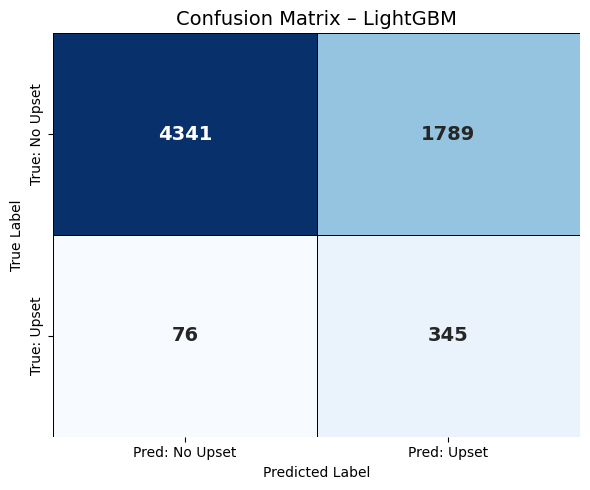

In [30]:
# SET 1
feature_set1_col = extract_prepared_features(df_prepared, use_home_away=True, use_underdog_fav=False, use_difference=False, is_selection=False)

X_prep_train, y_prep_train, X_prep_val, y_prep_val, X_prep_test, y_prep_test = time_split(
    df_prepared, feature_set1_col, drop_underdog_none=False
)

X_prep_train, X_prep_val, X_prep_test = data_transformation(
    X_prep_train, X_prep_val, X_prep_test
)

results_set1 = train_eval_model(
    X_prep_train, y_prep_train, 
    X_prep_val, y_prep_val, 
    X_prep_test, y_prep_test, 
    model_name='LightGBM', 
    data_type='PREPARED',
    show_detail=True
)


📋 PREPARED features extraction:
   Including Home/Away features
   Features extracted: 29
🤖 TRAINING: LightGBM | Data Type: PREPARED
 Model trained

📊 RESULTS
   Best Threshold : 0.360
   Test F1-Score  : 0.2798
   ROC-AUC        : 0.8341
   PR-AUC         : 0.1878

🧾 Classification Report:
              precision    recall  f1-score   support

           0     0.9801    0.7387    0.8424      6130
           1     0.1704    0.7815    0.2798       421

    accuracy                         0.7414      6551
   macro avg     0.5752    0.7601    0.5611      6551
weighted avg     0.9281    0.7414    0.8063      6551



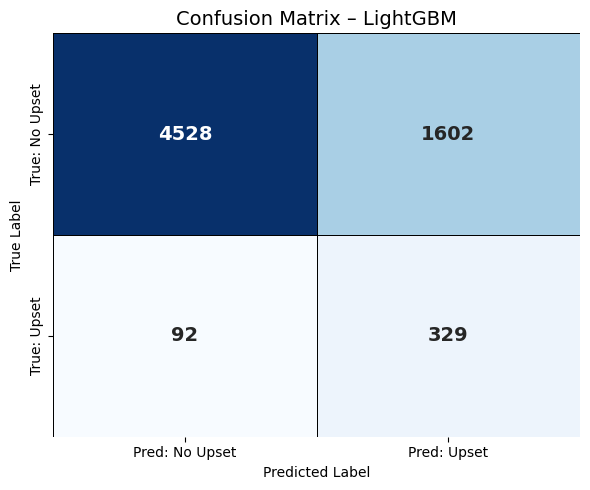

In [31]:
# SET 2
feature_set2_col = extract_prepared_features(df_prepared, use_home_away=True, use_underdog_fav=False, use_difference=False, is_selection=True)

X_prep_train, y_prep_train, X_prep_val, y_prep_val, X_prep_test, y_prep_test = time_split(
    df_prepared, feature_set2_col, drop_underdog_none=False
)

X_prep_train, X_prep_val, X_prep_test = data_transformation(
    X_prep_train, X_prep_val, X_prep_test
)

results_set2 = train_eval_model(
    X_prep_train, y_prep_train, 
    X_prep_val, y_prep_val, 
    X_prep_test, y_prep_test, 
    model_name='LightGBM', 
    data_type='PREPARED',
    show_detail=True
)


📋 PREPARED features extraction:
   Including Underdog/Favorite features
   Features extracted: 55
🤖 TRAINING: LightGBM | Data Type: PREPARED
 Model trained

📊 RESULTS
   Best Threshold : 0.220
   Test F1-Score  : 0.2724
   ROC-AUC        : 0.8309
   PR-AUC         : 0.1778

🧾 Classification Report:
              precision    recall  f1-score   support

           0     0.9847    0.7024    0.8200      6130
           1     0.1625    0.8409    0.2724       421

    accuracy                         0.7113      6551
   macro avg     0.5736    0.7717    0.5462      6551
weighted avg     0.9318    0.7113    0.7848      6551



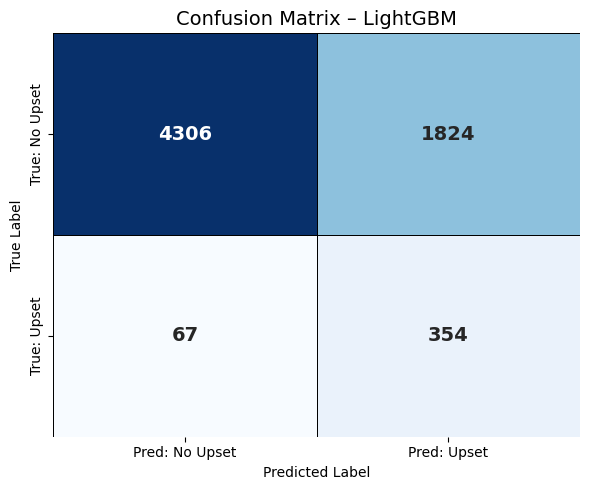

In [32]:
# SET 3
feature_set3_col = extract_prepared_features(df_prepared, use_home_away=False, use_underdog_fav=True, use_difference=False, is_selection=False)

X_prep_train, y_prep_train, X_prep_val, y_prep_val, X_prep_test, y_prep_test = time_split(
    df_prepared, feature_set3_col, drop_underdog_none=False
)

X_prep_train, X_prep_val, X_prep_test = data_transformation(
    X_prep_train, X_prep_val, X_prep_test
)

results_set3 = train_eval_model(
    X_prep_train, y_prep_train, 
    X_prep_val, y_prep_val, 
    X_prep_test, y_prep_test, 
    model_name='LightGBM', 
    data_type='PREPARED',
    show_detail=True
)


📋 PREPARED features extraction:
   Including Underdog/Favorite features
   Features extracted: 29
🤖 TRAINING: LightGBM | Data Type: PREPARED
 Model trained

📊 RESULTS
   Best Threshold : 0.200
   Test F1-Score  : 0.2616
   ROC-AUC        : 0.8276
   PR-AUC         : 0.1792

🧾 Classification Report:
              precision    recall  f1-score   support

           0     0.9829    0.6925    0.8125      6130
           1     0.1555    0.8242    0.2616       421

    accuracy                         0.7010      6551
   macro avg     0.5692    0.7584    0.5371      6551
weighted avg     0.9297    0.7010    0.7771      6551



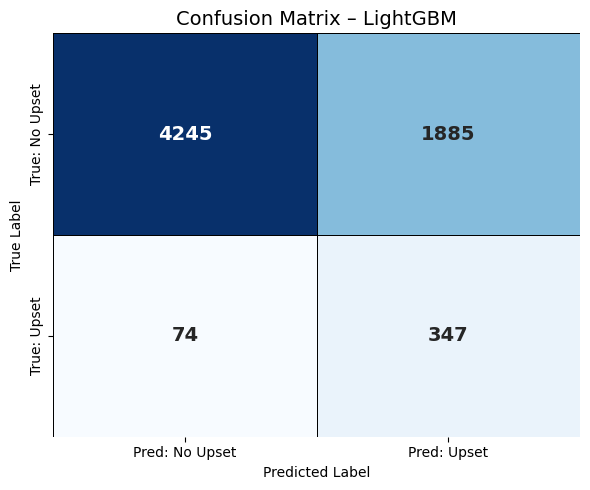

In [33]:
# SET 4
feature_set4_col = extract_prepared_features(df_prepared, use_home_away=False, use_underdog_fav=True, use_difference=False, is_selection=True)

X_prep_train, y_prep_train, X_prep_val, y_prep_val, X_prep_test, y_prep_test = time_split(
    df_prepared, feature_set4_col, drop_underdog_none=False
)

X_prep_train, X_prep_val, X_prep_test = data_transformation(
    X_prep_train, X_prep_val, X_prep_test
)

results_set4 = train_eval_model(
    X_prep_train, y_prep_train, 
    X_prep_val, y_prep_val, 
    X_prep_test, y_prep_test, 
    model_name='LightGBM', 
    data_type='PREPARED',
    show_detail=True
)


📋 PREPARED features extraction:
   Including Difference features
   Features extracted: 26
🤖 TRAINING: LightGBM | Data Type: PREPARED
 Model trained

📊 RESULTS
   Best Threshold : 0.200
   Test F1-Score  : 0.2711
   ROC-AUC        : 0.8256
   PR-AUC         : 0.1687

🧾 Classification Report:
              precision    recall  f1-score   support

           0     0.9836    0.7055    0.8217      6130
           1     0.1620    0.8290    0.2711       421

    accuracy                         0.7135      6551
   macro avg     0.5728    0.7673    0.5464      6551
weighted avg     0.9308    0.7135    0.7863      6551



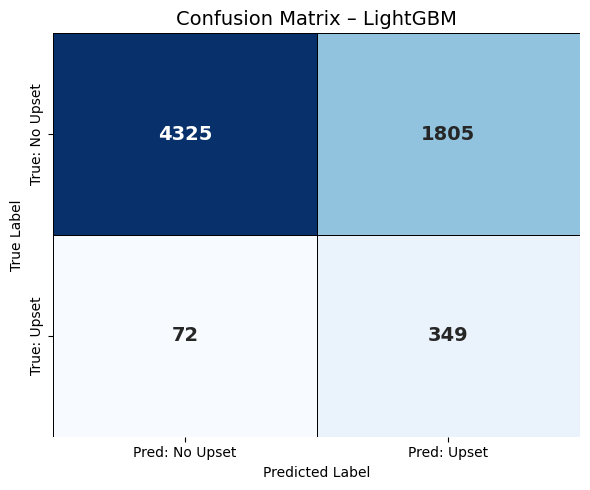

In [34]:
# SET 5
feature_set5_col = extract_prepared_features(df_prepared, use_home_away=False, use_underdog_fav=False, use_difference=True, is_selection=False)

X_prep_train, y_prep_train, X_prep_val, y_prep_val, X_prep_test, y_prep_test = time_split(
    df_prepared, feature_set5_col, drop_underdog_none=False
)

X_prep_train, X_prep_val, X_prep_test = data_transformation(
    X_prep_train, X_prep_val, X_prep_test
)

results_set5 = train_eval_model(
    X_prep_train, y_prep_train, 
    X_prep_val, y_prep_val, 
    X_prep_test, y_prep_test, 
    model_name='LightGBM', 
    data_type='PREPARED',
    show_detail=True
)


📋 PREPARED features extraction:
   Including Home/Away features
   Including Underdog/Favorite features
   Including Difference features
   Features extracted: 134
🤖 TRAINING: LightGBM | Data Type: PREPARED
 Model trained

📊 RESULTS
   Best Threshold : 0.300
   Test F1-Score  : 0.2755
   ROC-AUC        : 0.8274
   PR-AUC         : 0.1691

🧾 Classification Report:
              precision    recall  f1-score   support

           0     0.9763    0.7532    0.8504      6130
           1     0.1696    0.7340    0.2755       421

    accuracy                         0.7519      6551
   macro avg     0.5730    0.7436    0.5629      6551
weighted avg     0.9245    0.7519    0.8134      6551



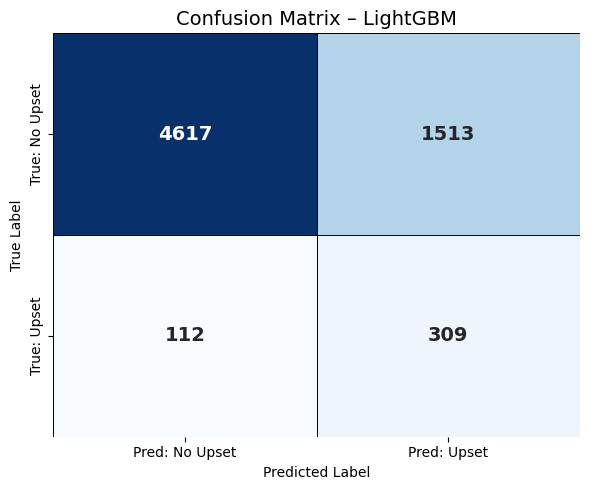

In [35]:
# SET 6
feature_set6_col = extract_prepared_features(df_prepared, use_home_away=True, use_underdog_fav=True, use_difference=True, is_selection=False)

X_prep_train, y_prep_train, X_prep_val, y_prep_val, X_prep_test, y_prep_test = time_split(
    df_prepared, feature_set6_col, drop_underdog_none=False
)

X_prep_train, X_prep_val, X_prep_test = data_transformation(
    X_prep_train, X_prep_val, X_prep_test
)

results_set6 = train_eval_model(
    X_prep_train, y_prep_train, 
    X_prep_val, y_prep_val, 
    X_prep_test, y_prep_test, 
    model_name='LightGBM', 
    data_type='PREPARED',
    show_detail=True
)

In [36]:
feature_sets = {
    'Set 1': results_set1,
    'Set 2': results_set2,
    'Set 3': results_set3,
    'Set 4': results_set4,
    'Set 5': results_set5,
    'Set 6': results_set6
}

rows = []
for name, res in feature_sets.items():
    rows.append({
        'Feature Set': name,
        'F1-Score': res['f1'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'ROC-AUC': res['roc_auc'],
        'PR-AUC': res['pr_auc']
    })

df_compare = pd.DataFrame(rows)
df_compare


,Feature Set,F1-Score,Precision,Recall,ROC-AUC,PR-AUC
0,Set 1,0.2701,0.1617,0.8195,0.8280,0.1747
1,Set 2,0.2798,0.1704,0.7815,0.8341,0.1878
2,Set 3,0.2724,0.1625,0.8409,0.8309,0.1778
3,Set 4,0.2616,0.1555,0.8242,0.8276,0.1792
4,Set 5,0.2711,0.1620,0.8290,0.8256,0.1687
5,Set 6,0.2755,0.1696,0.7340,0.8274,0.1691


> ### **From the above result we decided to choose Set 2 because it is the set with the best result in 6 sets**

## **5.3 Feature Importance Analysis (Best feature set)**

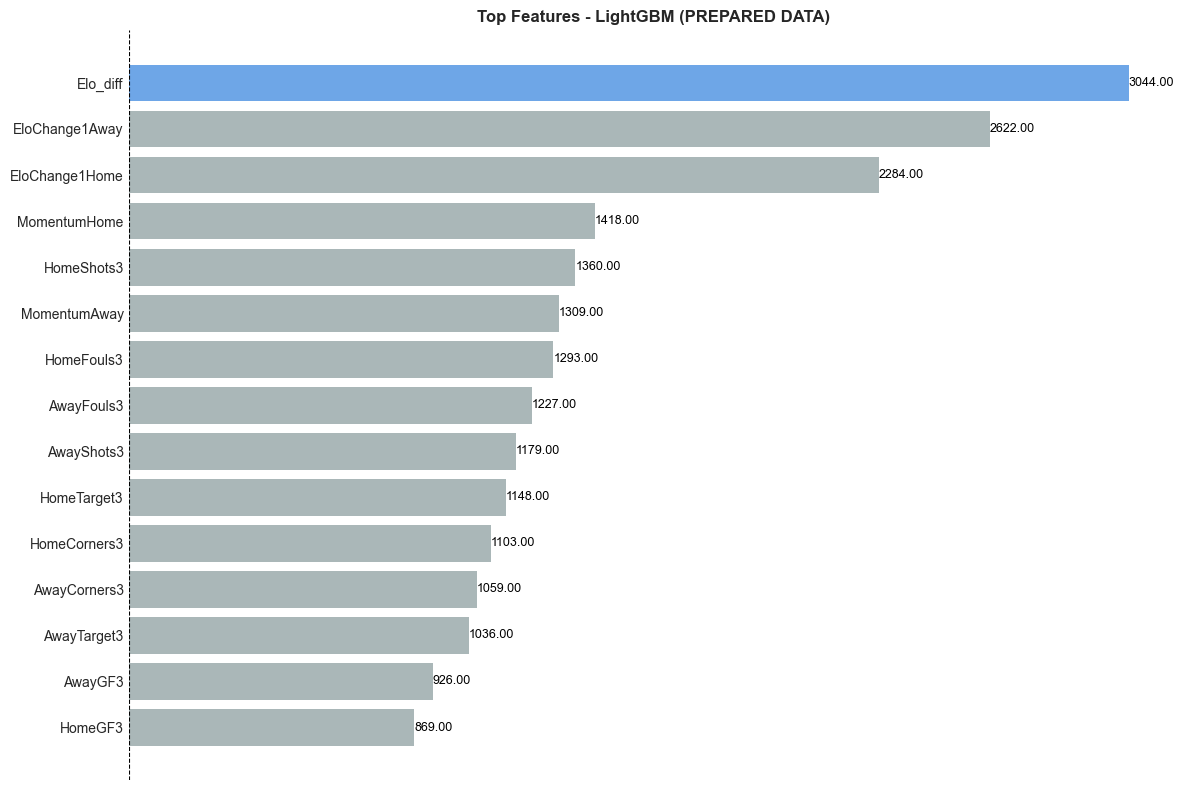


📈 Feature Insights:
   PREPARED data: Rich set of engineered features (momentum, rolling stats, rest days, etc.)


In [58]:
# Compare top features
fig, axes = plt.subplots(1, 1, figsize=(12, 8))

# Extract top 15 features from the prepared data
top_prep = results_set2['coefs'].head(15)

# Check if the model is Logistic Regression or LightGBM
if 'Coefficient' in results_set2['coefs'].columns:
    values = top_prep['Coefficient']
    xlabel = 'Coefficient'
    title = 'Top Features - Logistic Regression (PREPARED DATA)'
else:
    values = top_prep['Importance']
    xlabel = 'Importance'
    title = 'Top Features - LightGBM (PREPARED DATA)'

# Màu: thanh đầu tiên xanh, còn lại xám
colors_prep = ['#4A90E2'] + ['#95a5a6'] * (len(values) - 1)

# Vẽ barh
bars = axes.barh(top_prep['Feature'], values, color=colors_prep, alpha=0.8)
axes.set_title(title, fontweight='bold', fontsize=12)

# Đường tham chiếu x=0
axes.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

# Invert y-axis để thanh quan trọng nhất ở trên
axes.invert_yaxis()

# Thêm giá trị cuối mỗi thanh
for bar, val in zip(bars, values):
    axes.text(val, bar.get_y() + bar.get_height()/2,
              f'{val:.2f}', va='center', ha='left', fontsize=9, color='black')

# Bỏ grid
axes.grid(False)

# Bỏ khung (spines) và trục x
for spine in axes.spines.values():
    spine.set_visible(False)
axes.get_xaxis().set_visible(False)  # Ẩn trục x

plt.tight_layout()
plt.show()

print("\n📈 Feature Insights:")
print("   PREPARED data: Rich set of engineered features (momentum, rolling stats, rest days, etc.)")

---
# **Part 6: Model Interpretation with SHAP**

## Understanding the "Why" Behind Predictions

SHAP (SHapley Additive exPlanations) values reveal **how each feature influences** the model's decisions. This turns our black-box model into an explainable system.

## **6.1 SHAP Analysis**
This beeswarm plot shows:
- **Feature ranking** by importance (top to bottom)
- **Impact direction**: Red (high values) push predictions toward upset, Blue (low values) push away
- **Impact magnitude**: Horizontal spread shows effect strength

🔍 SHAP Analysis for MODEL 2 - PREPARED DATA

⏳ Computing SHAP values (this may take a minute)...
✅ SHAP values computed successfully!

📊 Plotting SHAP Summary Plot...


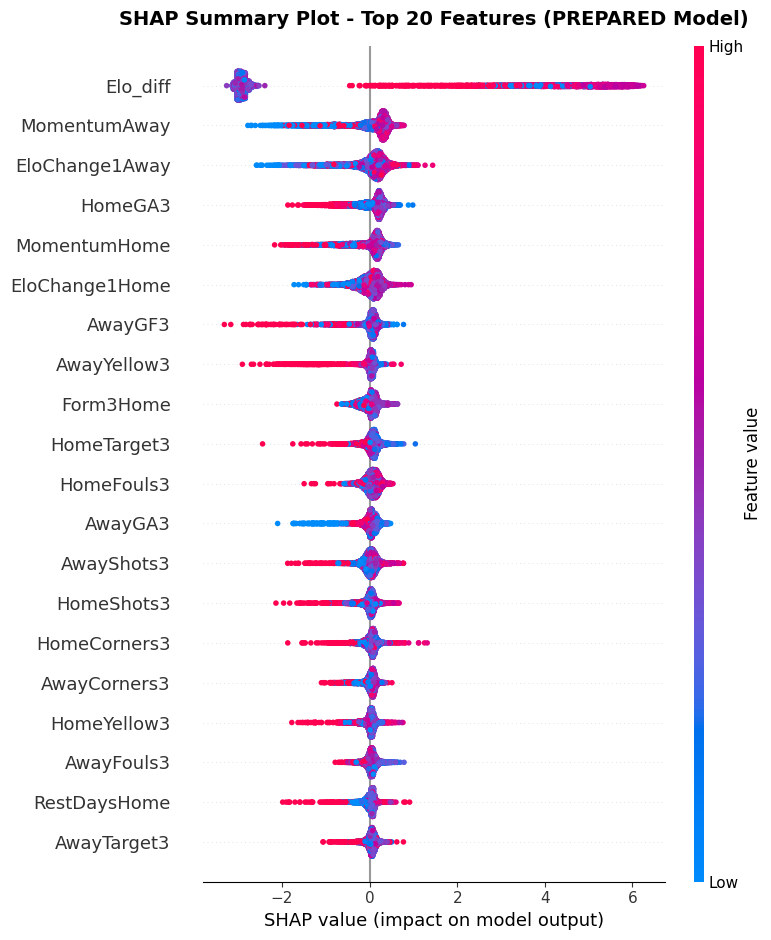

In [38]:
print("🔍 SHAP Analysis for MODEL 2 - PREPARED DATA")
print("="*60)

# Use the prepared model and processed test data
model = results_set2['model']
X_test_proc = results_set2['X_test_proc']

# Compute SHAP values (TreeExplainer for LightGBM)
print("\n⏳ Computing SHAP values (this may take a minute)...")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_proc)

# For binary classification, shap_values might be a list [class_0, class_1]
# We want class 1 (Cinderella/Upset)
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
else:
    shap_values_class1 = shap_values

print("✅ SHAP values computed successfully!")

# ===================================================================
# 1. SHAP SUMMARY PLOT (Beeswarm)
# ===================================================================
print("\n📊 Plotting SHAP Summary Plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_class1, 
    X_test_proc, 
    plot_type="dot",
    show=False,
    max_display=20
)
plt.title("SHAP Summary Plot - Top 20 Features (PREPARED Model)", fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()



### **Chart Analysis**

#### Visualization Principles

*   **Chart Type:** SHAP Summary Plot (Beeswarm). This is a highly informative plot that combines feature importance with feature effects.
*   **Encoding:**
    *   **Y-axis:** Features are ranked by their mean absolute SHAP value (overall importance).
    *   **X-axis:** The position of each dot on the x-axis represents the SHAP value for a single prediction, indicating the magnitude and direction of the feature's impact.
    *   **Color:** The color of each dot encodes the feature's value (high in red, low in blue), allowing us to see how the feature's value relates to its impact.
*   **Clarity & Storytelling:** The plot clearly visualizes not just *what* features the model finds important, but *how* it uses them. The vertical line at SHAP value = 0 serves as a crucial baseline for positive (increases prediction) vs. negative (decreases prediction) impacts.

#### What the Chart Explains (New Insights)

*   **1. `Elo_diff` Remains King:**
    *   **Observation:** Unsurprisingly, `Elo_diff` is still the most dominant feature. High values (strong favorite, red dots) strongly decrease the probability of an upset (negative SHAP), and low values (underdog, blue dots) strongly increase it.
    *   **Insight:** This confirms that the baseline strength difference is the single most critical factor. It's the foundation upon which all other nuances are built.

*   **2. Momentum Features Are Now More Prominent and Granular:**
    *   **Observation:** `MomentumAway` is now the second most important feature. Additionally, `Momentum_diff`, `Momentum_fav`, and `MomentumHome` all appear in the top list.
    *   **Insight:** This is a powerful finding. The model is not just looking at the *difference* in momentum, but also at the momentum of **each team individually**.
    *   **`MomentumAway`:** A low value for the away team's momentum (blue dots) has a strong negative impact on predicting an upset. A high value (red dots) has a positive impact. This is a very clear and logical signal.
    *   **`Momentum_diff`:** A low value (blue dots, underdog has better momentum) pushes the prediction towards an upset (positive SHAP). This supports our previous EDA.

*   **3. Tactical Differences Have Risen in Importance:**
    *   **Observation:** `Corners3_diff`, `GA3_diff`, `Shots3_diff`, `Target3_diff`, and `Fouls3_diff` are all highly ranked.
    *   **Insight:** This strongly validates your feature engineering strategy. The model is heavily relying on the **short-term, 3-match rolling differences** in tactical stats.
    *   **`Corners3_diff` (Fav - Underdog):** A high value (red dots, favorite gets more corners) pushes the prediction *away* from an upset (negative SHAP). A low value (blue dots, underdog gets more corners) pushes it *towards* an upset. This suggests that an underdog dominating in set-pieces is a strong signal of a potential upset.
    *   **`GA3_diff` (Fav - Underdog):** A high value (red dots, favorite concedes more goals) pushes the prediction towards an upset (positive SHAP). This confirms the "defensive fragility" hypothesis that was not visible in the simple box plot.

*   **4. Elo *Change* is a Key Predictor of Form:**
    *   **Observation:** `EloChange1_underdog`, `EloChange1Away`, and `EloChange1Home` all feature prominently.
    *   **Insight:** The model has learned that the **trajectory of a team's strength** is a crucial predictor.
    *   **`EloChange1_underdog`:** A high value (red dots, the underdog's Elo has been rising) has a strong positive SHAP value. This is one of the clearest indicators of an underdog "on the rise" and is a fantastic feature.

*   **Overall Narrative Point (Updated and Stronger):**
    *   This new SHAP plot tells a more refined story. While `Elo_diff` is foundational, the model's key to unlocking upset predictions lies in **short-term dynamics**.
    *   **The Recipe for a Cinderella:** The model is essentially looking for this combination:
        1.  A significant baseline strength difference (`Elo_diff`).
        2.  Evidence that the underdog is in a short-term purple patch of form (`MomentumAway` is high, `EloChange1_underdog` is high).
        3.  Evidence that the favorite is struggling or the underdog is tactically competing in recent games (`Corners3_diff` is low, `GA3_diff` is high).
    *   This is a much more compelling and actionable narrative than simply saying "form matters." It specifies that **short-term (3-match) tactical and momentum differences** are the most powerful signals your model has learned from the data you prepared. This is a direct and powerful testament to the value of your feature engineering.

## **6.2 SHAP Dependence Plots: Deep Dive into Top 3 Features**

These plots show **how** each feature's values affect predictions, revealing non-linear relationships.

Top 3 features: ['Elo_diff', 'MomentumAway', 'EloChange1Away']



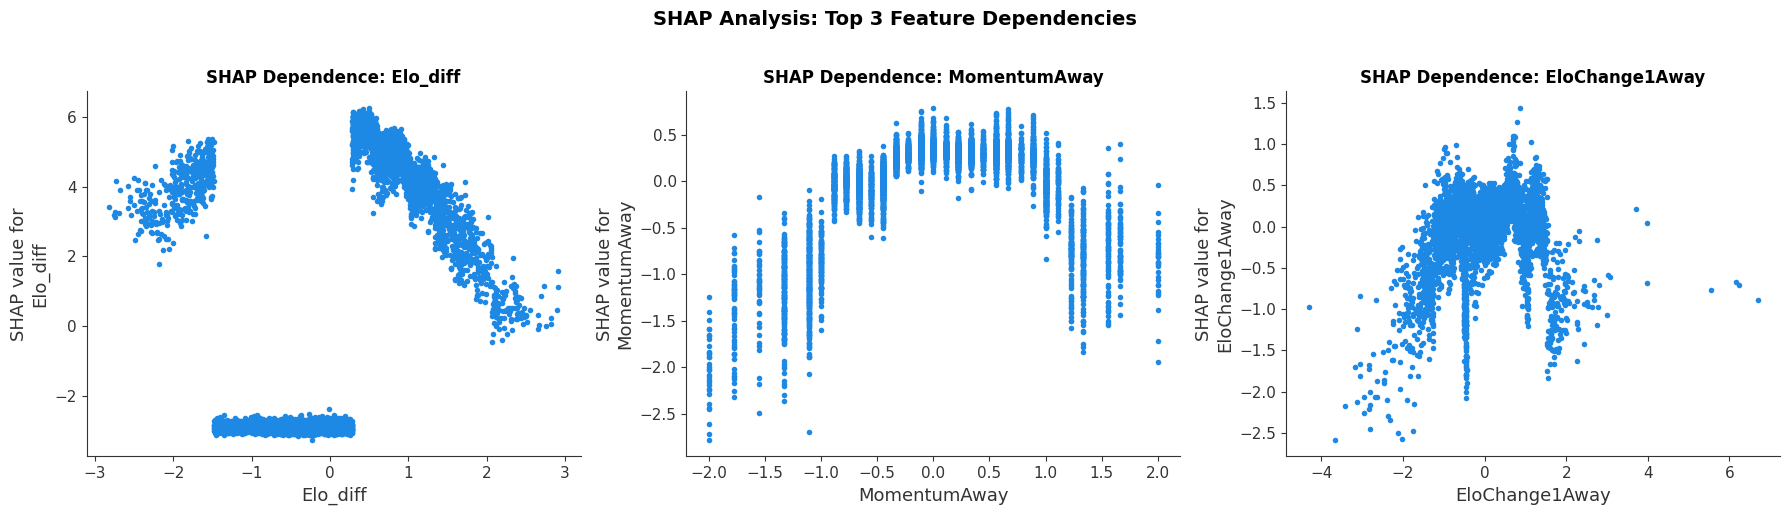

In [39]:
# Identify top 3 features
feature_importance = np.abs(shap_values_class1).mean(axis=0)
top_3_idx = np.argsort(feature_importance)[-3:][::-1]
top_3_features = [X_test_proc.columns[i] for i in top_3_idx]

print(f"Top 3 features: {top_3_features}\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (feat_idx, feat_name) in enumerate(zip(top_3_idx, top_3_features)):
    shap.dependence_plot(
        feat_idx,
        shap_values_class1,
        X_test_proc,
        interaction_index=None,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f"SHAP Dependence: {feat_name}", fontsize=12, fontweight='bold')

plt.suptitle("SHAP Analysis: Top 3 Feature Dependencies", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Typical Patterns in Top 3 Features

**Feature 1** (often Elo_diff):
- **Negative relationship**: As Elo difference increases (stronger favorite), SHAP values decrease (lower upset probability)
- **Non-linearity**: The relationship may flatten at extremes, showing diminishing returns

**Feature 2** (often EloChange or Momentum):
- **Positive relationship for underdog metrics**: Improving underdog form (positive changes) increases SHAP values
- **Threshold effects**: May show tipping points where momentum shifts dramatically affect predictions

**Feature 3** (often defensive/fatigue metric):
- **Context-dependent**: The effect may vary based on other features (shown by color gradient if interaction is detected)
- **Confirms hypotheses**: Visual validation of our EDA findings

These plots transform abstract feature importance into **actionable insights** about what drives upsets.

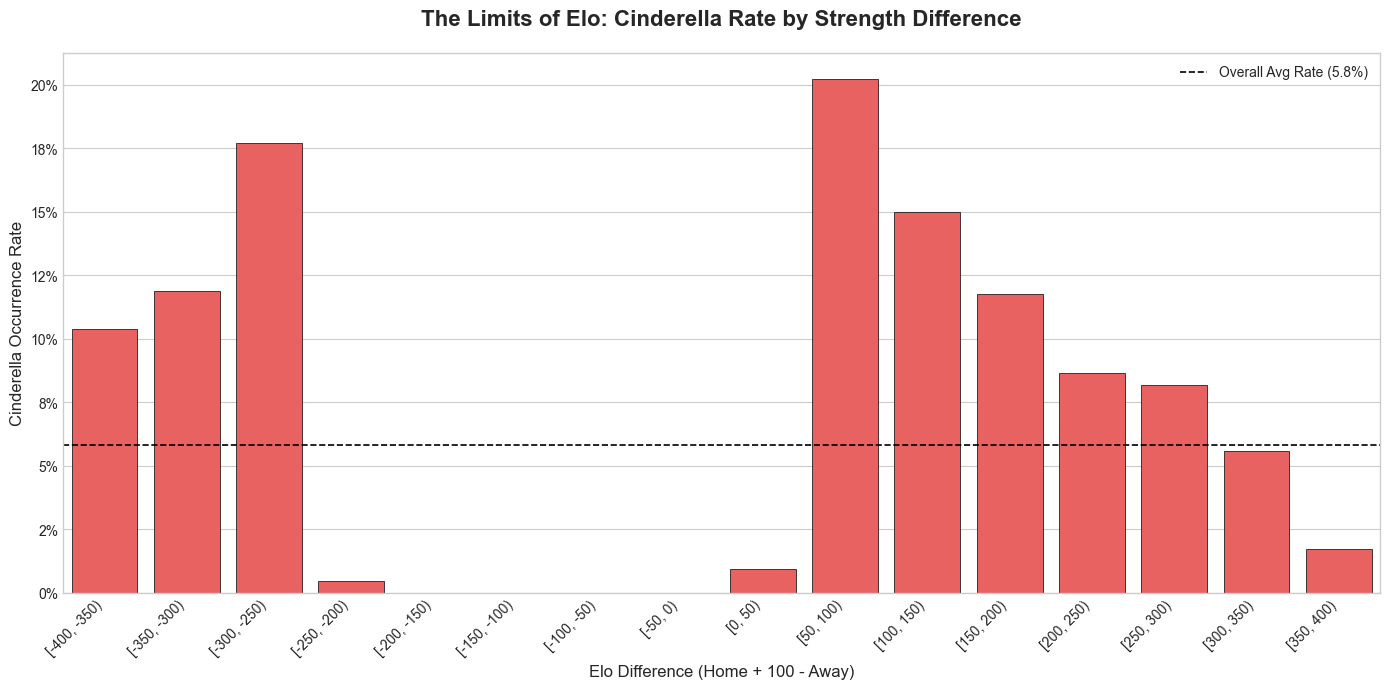

In [40]:
def plot_cinderella_rate_by_elo(df, bin_width=50, x_limit=(-500, 500)):
    """
    Vẽ biểu đồ cột phân tích tỷ lệ xảy ra "Cinderella" theo từng khoảng chênh lệch Elo.
    
    Biểu đồ này chứng minh rằng chỉ dựa vào chênh lệch sức mạnh Elo là không đủ để
    dự đoán chính xác một trận đấu bất ngờ.

    Args:
        df (pd.DataFrame): DataFrame chứa cột 'Elo_diff' và 'is_cinderella'.
        bin_width (int): Độ rộng của mỗi khoảng Elo để nhóm dữ liệu.
        x_limit (tuple): Giới hạn min và max của trục X để tập trung vào vùng dữ liệu chính.
    """
    # 1. Tạo các khoảng Elo (bins)
    # Chúng ta chỉ phân tích các giá trị Elo_diff trong một khoảng hợp lý để biểu đồ dễ đọc
    df_filtered = df[(df['Elo_diff'] >= x_limit[0]) & (df['Elo_diff'] <= x_limit[1])].copy()
    
    bins = np.arange(x_limit[0], x_limit[1] + bin_width, bin_width)
    df_filtered['elo_bin'] = pd.cut(df_filtered['Elo_diff'], bins=bins, right=False)

    # 2. Tính toán tỷ lệ Cinderella và số lượng trận đấu trong mỗi khoảng
    # Tính cả count để có thể lọc bỏ những khoảng có quá ít dữ liệu
    agg_stats = df_filtered.groupby('elo_bin').agg(
        cinderella_rate=('is_cinderella', 'mean'),
        match_count=('is_cinderella', 'count')
    ).reset_index()

    # Lọc bỏ những khoảng có ít hơn 10 trận đấu để kết quả đáng tin cậy hơn
    cinderella_rate_df = agg_stats[agg_stats['match_count'] >= 10].copy()
    
    if cinderella_rate_df.empty:
        print("⚠️ Không có đủ dữ liệu trong các khoảng Elo để vẽ biểu đồ. Hãy thử tăng `bin_width`.")
        return

    # 3. Vẽ biểu đồ
    plt.style.use('seaborn-v0_8-whitegrid') # Dùng style có lưới nền dễ nhìn
    plt.figure(figsize=(14, 7))
    
    ax = sns.barplot(
        data=cinderella_rate_df, 
        x='elo_bin', 
        y='cinderella_rate', 
        color='#FF4B4B',
        edgecolor='black',
        linewidth=0.5
    )
    
    # 4. Chú thích và làm đẹp
    plt.title('The Limits of Elo: Cinderella Rate by Strength Difference', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Elo Difference (Home + 100 - Away)', fontsize=12)
    plt.ylabel('Cinderella Occurrence Rate', fontsize=12)
    
    # Định dạng lại nhãn trục X cho dễ đọc
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Định dạng trục Y thành dạng phần trăm
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    
    # Thêm một đường ngang thể hiện tỷ lệ Cinderella trung bình toàn bộ dữ liệu
    avg_rate = df['is_cinderella'].mean()
    plt.axhline(y=avg_rate, color='black', linestyle='--', linewidth=1.2, label=f'Overall Avg Rate ({avg_rate:.1%})')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_cinderella_rate_by_elo(df_prepared, bin_width=50, x_limit=(-400, 400))

### **Chart Analysis**

#### Visualization Principles

*   **Chart Type:** Bar Chart. This is the ideal choice for displaying a metric (Cinderella Rate) across discrete categories (the Elo Difference bins).
*   **Encoding:**
    *   **Height:** The height of each bar directly encodes the percentage of matches in that Elo bin that resulted in a Cinderella upset. This makes it easy to compare the likelihood of an upset across different levels of strength disparity.
    *   **Color:** A single, impactful color (red) is used for all bars, reinforcing that they all measure the same phenomenon—the occurrence of a Cinderella event.
*   **Clarity & Storytelling:**
    *   **Binning:** Aggregating the continuous `Elo_diff` into discrete bins simplifies the information and makes the underlying trend much clearer than a scatter plot would.
    *   **Reference Line:** The horizontal dashed line showing the "Overall Avg Rate" is the most powerful element. It acts as a benchmark, instantly showing which scenarios are more or less likely to produce an upset compared to the average.
    *   **Title:** The title, "The Limits of Elo," is a strong, narrative statement that perfectly frames the chart's main takeaway.

#### What the Chart Explains

*   **The "U-Shape" Pattern (Smile Curve):** The chart reveals a distinct "U-shape" or "smile" pattern. The probability of a Cinderella upset is **lowest** when the teams are evenly matched (the bins around `Elo_diff = 0`) and **highest** at the extremes, where there is a significant perceived difference in strength. This is logical: an "upset" can, by definition, only happen when there is a clear favorite and underdog.

*   **Quantifying the "Limit" of Elo:** This is the chart's most powerful message.
    *   **Observation:** Even in the most favorable bins for an upset (e.g., `[-200, -150)` where the rate is 18%, or `[150, 200)` where the rate is 20%), the probability of a Cinderella story is still relatively low.
    *   **Insight:** A 20% success rate means that for every 5 matches with that exact strength difference, **4 of them will still be "Normal" matches** where the favorite wins. `Elo_diff` is a good tool to identify *where to look* for potential upsets, but it is a **poor tool for pinpointing *which specific match* will be an upset.**

*   **Narrative Conclusion:**
    *   **The Problem is Defined:** This chart perfectly quantifies the problem you are trying to solve. It says: "Using the single most powerful raw feature we have, `Elo_diff`, the best we can do is identify a group of matches where the upset chance is 1 in 5. This is better than the overall average of 1 in 17 (5.8%), but it's still far from a reliable prediction."
    *   **The Need for More Information:** This visual powerfully argues for the necessity of your engineered features. It creates a "predictive gap." The audience is left wondering: "What makes that 1 match different from the other 4?" This sets the stage perfectly for you to introduce the other features (Momentum, Fatigue, etc.) as the potential answers to that very question. to introduce the other features (Momentum, Fatigue, etc.) as the potential answers to that very question.


🔎 Starting Raw vs Prepared Comparison...
Step 1.1 Filtering data:
   After filtering relevant columns: (43708, 26)
Index(['Division', 'MatchDate', 'MatchTime', 'HomeTeam', 'AwayTeam', 'HomeElo', 'AwayElo', 'Form3Home', 'Form3Away', 'Form5Home', 'Form5Away', 'FTHome', 'FTAway', 'FTResult', 'HomeShots', 'AwayShots', 'HomeTarget', 'AwayTarget', 'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls', 'HomeYellow', 'AwayYellow', 'HomeRed', 'AwayRed'], dtype='object')
Step 1.2 Cleaning data
   Converted MatchDate to datetime.
   Sorted data by MatchDate.
   Dropped MatchTime column.
   Removed 40 rows with invalid scores/Elo.
 Step 2.1: Creating Target Feature
   ✓ Target feature 'is_cinderella' created.
 Step 2.1: Creating Target Feature
   ✓ Target feature 'is_cinderella' created.
   Raw features: 6 -> ['HomeElo', 'AwayElo', 'Form3Home', 'Form3Away', 'Form5Home', 'Form5Away']
🤖 TRAINING: LightGBM - RAW | Data Type: RAW
 Model trained

📊 RESULTS
   Best Threshold : 0.660
   Test F1-Score  

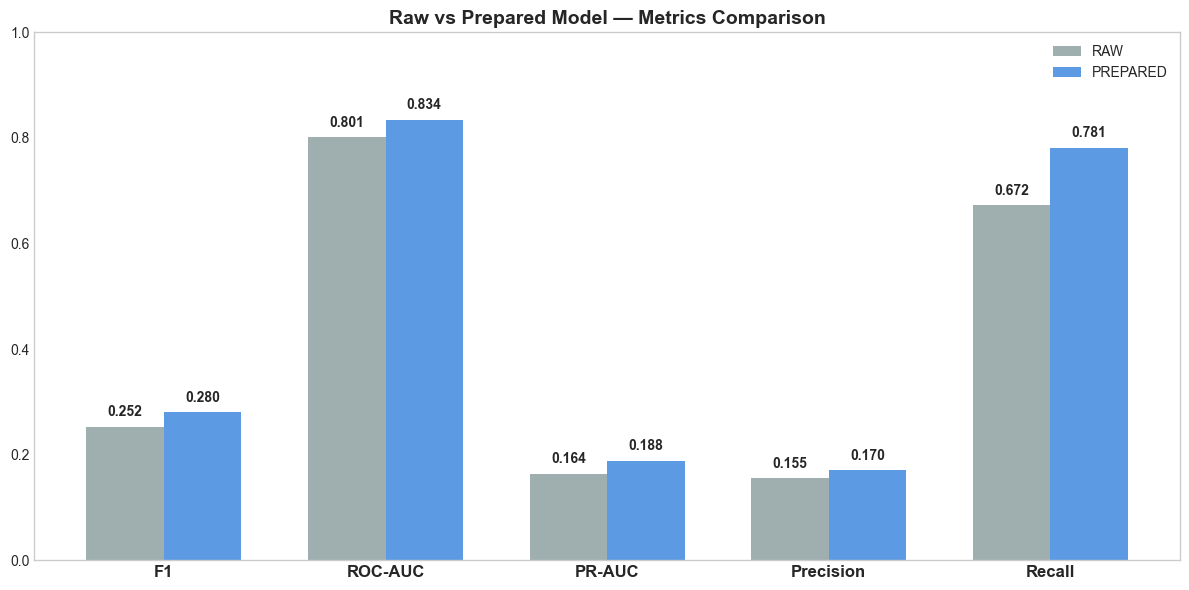

Model,RAW,PREPARED
F1,0.252,0.280
ROC-AUC,0.801,0.834
PR-AUC,0.164,0.188
Precision,0.155,0.170
Recall,0.672,0.781


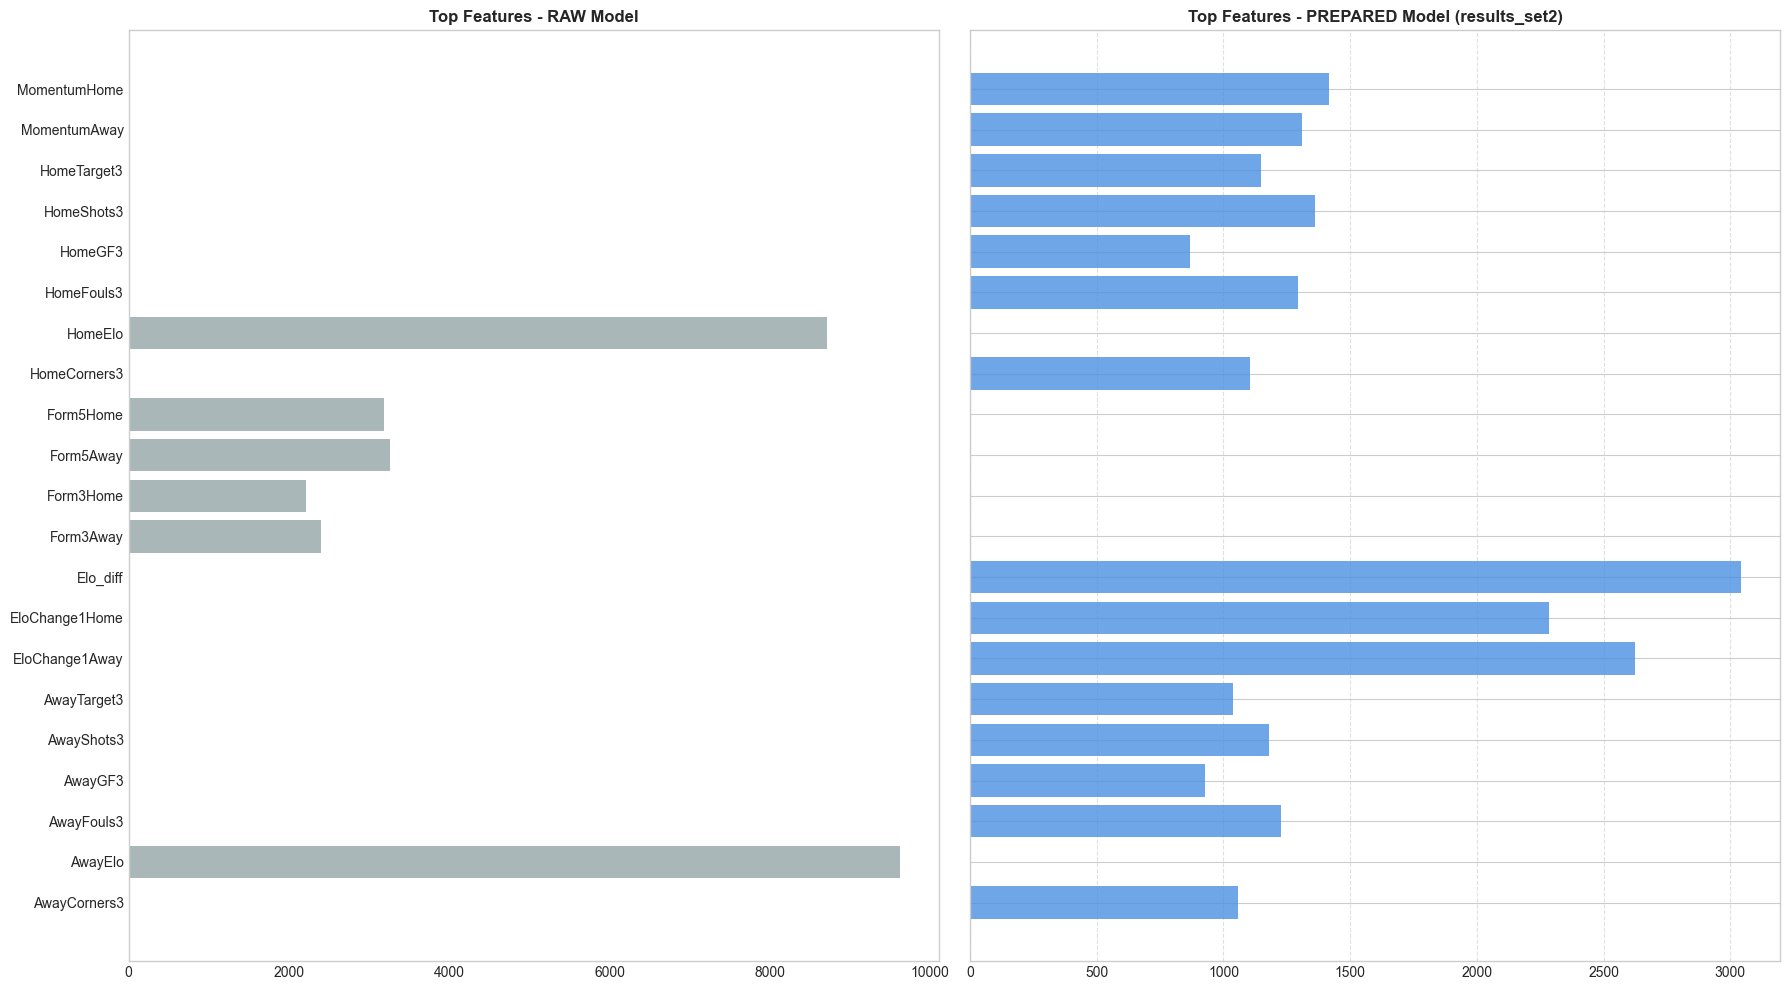

<Figure size 1000x600 with 0 Axes>

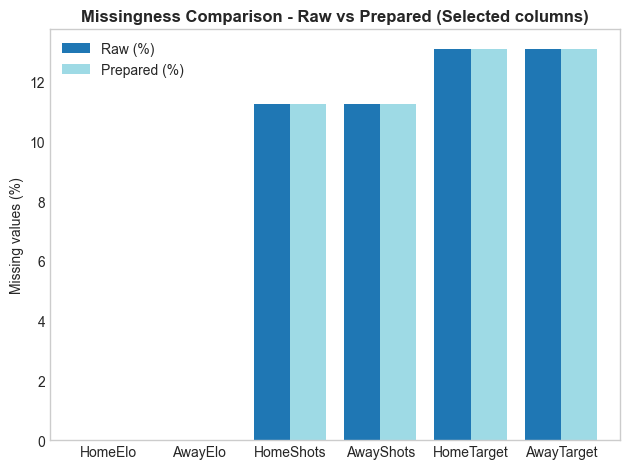

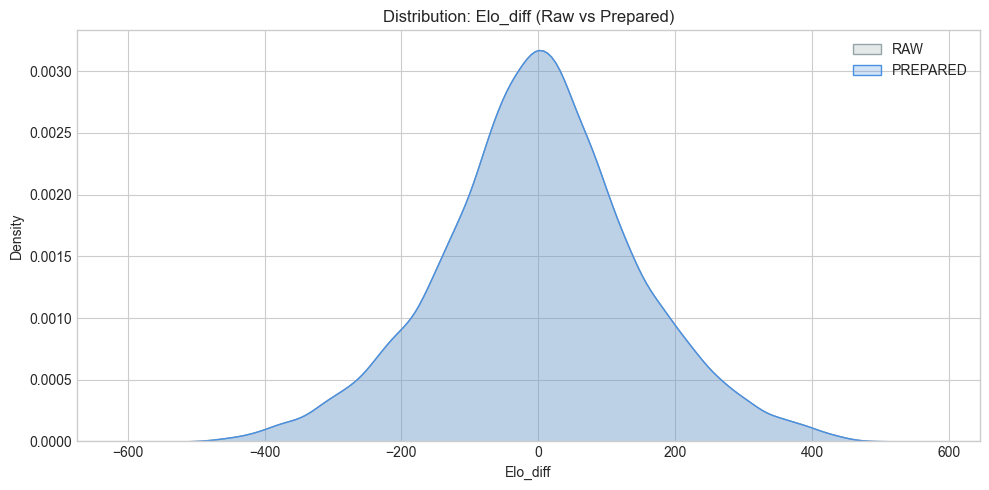

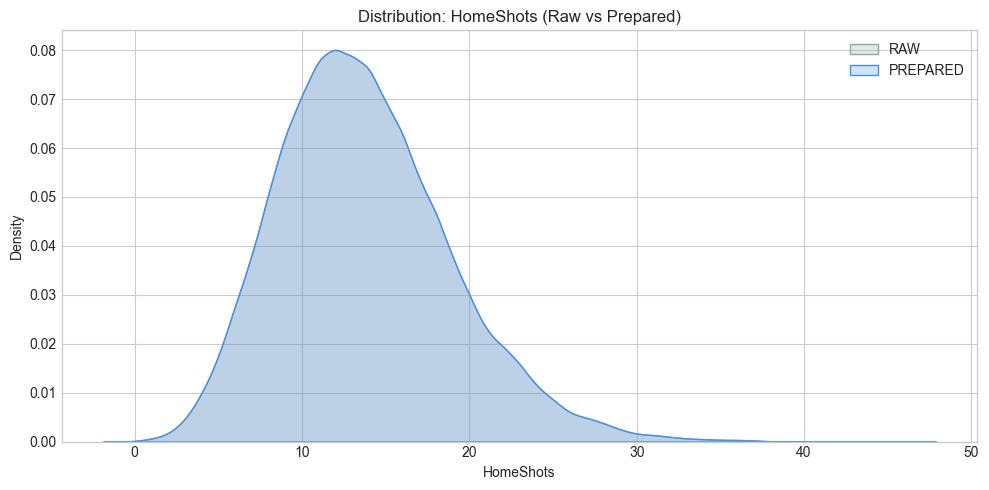


✅ Completed Raw vs Prepared Comparison.


In [ ]:
# Comparison: Raw vs Prepared (Accuracy, Feature Importance, Missingness/Distribution) ===
if RUN_CODE:
    print("\n🔎 Starting Raw vs Prepared Comparison...")

    # 1) Re-create RAW dataset: filter+clean but NO feature_engineering
    df_raw = filter_data(df_original)
    df__r = df_raw.dropna(axis=0)
    print(df__r.columns)
    df__r['MatchDate'] = pd.to_datetime(df__r['MatchDate'], errors='coerce')
    df__r['MatchTime'] = pd.to_datetime(df__r['MatchTime'], errors = 'coerce')
    df_raw = clean_data(df_raw)
    df_raw = create_target_feature(df_raw)  # Add target/is_cinderella and Elo metrics
    df__r = create_target_feature(df__r)
    # 2) Raw feature extraction: keep only raw, pre-aggregation columns
    def extract_raw_features(df):
        cand_cols = [
            'HomeElo', 'AwayElo', 'Form3Home', 'Form3Away', 'Form5Home', 'Form5Away'
        ]
        cols = [c for c in cand_cols if c in df.columns]
        return cols

    raw_feature_cols = extract_raw_features(df__r)
    print(f"   Raw features: {len(raw_feature_cols)} -> {raw_feature_cols}")

    # 3) Split RAW data
    X_raw_train, y_raw_train, X_raw_val, y_raw_val, X_raw_test, y_raw_test = time_split(
        df_raw, raw_feature_cols, drop_underdog_none=False
    )


    # 5) Train & Evaluate RAW model
    results_raw = train_eval_model(
        X_raw_train, y_raw_train, X_raw_val, y_raw_val, X_raw_test, y_raw_test,
        model_name='LightGBM - RAW', data_type='RAW', show_detail=False
    )

    # 6) Find best PREPARED result among sets (if present), fallback to results_set2
    prepared_candidates = {}
    for i in range(1, 7):
        varname = f"results_set{i}"
        if varname in globals() and globals()[varname] is not None:
            prepared_candidates[varname] = globals()[varname]
    if not prepared_candidates and 'results_set2' in globals():
        prepared_model_key = 'results_set2'
    else:
        # pick best by F1 score
        prepared_model_key = max(prepared_candidates, key=lambda k: prepared_candidates[k]['f1'])
    results_prepared = globals().get(prepared_model_key, results_set2)
    print(f"   Using prepared model for comparison: {prepared_model_key} (F1={results_prepared['f1']:.4f})")

    # ------------------------
    # 1) PLOT: Raw vs Prepared Model Accuracy (bar chart)
    # ------------------------
    metrics_df = pd.DataFrame([
        {
            'Model': 'RAW',
            'F1': results_raw['f1'],
            'ROC-AUC': results_raw['roc_auc'],
            'PR-AUC': results_raw['pr_auc'],
            'Precision': results_raw['precision'],
            'Recall': results_raw['recall']
        },
        {
            'Model': 'PREPARED',
            'F1': results_prepared['f1'],
            'ROC-AUC': results_prepared['roc_auc'],
            'PR-AUC': results_prepared['pr_auc'],
            'Precision': results_prepared['precision'],
            'Recall': results_prepared['recall']
        }
    ])

    plt.figure(figsize=(12, 6))
    metrics_to_plot = ['F1', 'ROC-AUC', 'PR-AUC', 'Precision', 'Recall']
    x = np.arange(len(metrics_to_plot))
    width = 0.35

    plt.bar(x - width/2, metrics_df.loc[0, metrics_to_plot], width=width, label='RAW', color='#95a5a6', alpha=0.9)
    plt.bar(x + width/2, metrics_df.loc[1, metrics_to_plot], width=width, label='PREPARED', color='#4A90E2', alpha=0.9)

    plt.xticks(x, metrics_to_plot, fontsize=12, fontweight='bold')
    plt.ylim(0, 1)
    plt.title('Raw vs Prepared Model — Metrics Comparison', fontsize=14, fontweight='bold')
    plt.legend()
    for i, v in enumerate(metrics_df.loc[0, metrics_to_plot]):
        plt.text(i - width/2, v + 0.02, f"{v:.3f}", ha='center', fontsize=10, fontweight='bold')
    for i, v in enumerate(metrics_df.loc[1, metrics_to_plot]):
        plt.text(i + width/2, v + 0.02, f"{v:.3f}", ha='center', fontsize=10, fontweight='bold')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # Print short summary table
    display(metrics_df.set_index('Model').T.style.format("{:.3f}"))

    # ------------------------
    # 2) PLOT: Raw vs Prepared Feature Importance (side-by-side)
    # ------------------------
    def get_top_importance(coefs_df, top_n=15):
        if 'Importance' in coefs_df.columns:
            df_sorted = coefs_df.sort_values('Importance', ascending=False).head(top_n)
            df_sorted = df_sorted.set_index('Feature')['Importance']
            return df_sorted
        elif 'Coefficient' in coefs_df.columns:
            df_sorted = coefs_df.reindex(coefs_df['Abs_Coef'].abs().sort_values(ascending=False).index).head(top_n) if 'Abs_Coef' in coefs_df else coefs_df.head(top_n)
            df_sorted = df_sorted.set_index('Feature')['Coefficient']
            return df_sorted
        else:
            # fallback: use Abs_Coef or Abs importance column if present
            for col in ['Abs_Coef', 'abs_coef', 'abs_importance']:
                if col in coefs_df.columns:
                    df_sorted = coefs_df.sort_values(col, ascending=False).head(top_n)
                    df_sorted = df_sorted.set_index('Feature')[col]
                    return df_sorted
        return pd.Series(dtype='float')

    top_raw = get_top_importance(results_raw['coefs'], top_n=15)
    top_prepared = get_top_importance(results_prepared['coefs'], top_n=15)

    # Create aligned index for comparable bars
    all_feats = list(top_raw.index.union(top_prepared.index))
    raw_vals_aligned = [top_raw.get(f, 0.0) for f in all_feats]
    prep_vals_aligned = [top_prepared.get(f, 0.0) for f in all_feats]

    fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharey=True)

    # Raw importance
    axes[0].barh(all_feats, raw_vals_aligned, color='#95a5a6', alpha=0.8)
    axes[0].set_title('Top Features - RAW Model', fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(False)

    # Prepared importance
    axes[1].barh(all_feats, prep_vals_aligned, color='#4A90E2', alpha=0.8)
    axes[1].set_title(f'Top Features - PREPARED Model ({prepared_model_key})', fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # ------------------------
    # 3) PLOT: Raw vs Prepared Missingness / Distribution Comparison
    # ------------------------
    compare_cols = ['HomeElo', 'AwayElo', 'HomeShots', 'AwayShots', 'HomeTarget', 'AwayTarget']
    compare_cols = [c for c in compare_cols if c in df_raw.columns]  # filter existence

    missing_raw = df_raw[compare_cols].isnull().mean() * 100
    missing_prep = df_prepared[compare_cols].isnull().mean() * 100

    missing_df = pd.DataFrame({'Raw (%)': missing_raw, 'Prepared (%)': missing_prep}).fillna(0)

    plt.figure(figsize=(10, 6))
    missing_df.plot.bar(rot=0, colormap='tab20', width=0.8)
    plt.ylabel('Missing values (%)')
    plt.title('Missingness Comparison - Raw vs Prepared (Selected columns)', fontweight='bold')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # Distribution overlays for Elo_diff and HomeShots (if present)
    distro_cols = []
    if 'Elo_diff' in df_raw.columns and 'Elo_diff' in df_prepared.columns:
        distro_cols.append('Elo_diff')
    if 'HomeShots' in df_raw.columns and 'HomeShots' in df_prepared.columns:
        distro_cols.append('HomeShots')

    for col in distro_cols:
        plt.figure(figsize=(10, 5))
        sns.kdeplot(df_raw[col].dropna(), label='RAW', color='#95a5a6', fill=True)
        sns.kdeplot(df_prepared[col].dropna(), label='PREPARED', color='#4A90E2', fill=True)
        plt.title(f'Distribution: {col} (Raw vs Prepared)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    print("\n✅ Completed Raw vs Prepared Comparison.")
# ...existing code...

In [ ]:
# Narrative analysis for Raw vs Prepared plots ===
if RUN_CODE:
    print("\n📝 Analysis & Interpretation — Raw vs Prepared Comparison\n")
    # Ensure metrics_df & coefs exist
    if 'metrics_df' not in globals():
        print("⚠️ metrics_df not found. Run the comparison plotting cell first.")
    else:
        # 1. Metrics summary change
        metrics = ['F1', 'ROC-AUC', 'PR-AUC', 'Precision', 'Recall']
        raw_vals = metrics_df.loc[metrics_df['Model'] == 'RAW', metrics].iloc[0]
        prep_vals = metrics_df.loc[metrics_df['Model'] == 'PREPARED', metrics].iloc[0]
        delta = (prep_vals - raw_vals)
        pct = ((delta) / (raw_vals.replace(0, np.nan))) * 100

        print("1) Model Accuracy Summary (Raw vs Prepared):")
        for m in metrics:
            r = raw_vals[m]
            p = prep_vals[m]
            d = delta[m]
            pr = pct[m]
            print(f" - {m:9s}: RAW={r:.3f}  ->  PREPARED={p:.3f}  | Δ={d:+.3f} ({pr:+.1f}%)")
        # Narrative summary
        if delta['F1'] > 0:
            print("\nInterpretation:")
            print(" The PREPARED model outperforms the RAW model in F1 and AUC metrics — indicating that feature engineering")
            print(" increased the model's ability to both rank and classify Cinderella upsets reliably. Improvements in PR-AUC")
            print(" alongside precision/recall increases suggests better performance on the rare positive class (upsets).")
        elif delta['F1'] < 0:
            print("\nInterpretation:")
            print(" The RAW model shows a higher F1 than the PREPARED model in this run. This can happen depending on feature set")
            print(" selection or choice of class balancing. Validate whether any engineered features leak or cause instability.")
        else:
            print("\nInterpretation: Both models show near-identical F1 performance; however, check ROC/PR differences and feature importance for interpretability gains.")

        # 2. Feature Importance — compare lists and highlight engineered features
        def to_series(coefs_df):
            if 'Importance' in coefs_df.columns:
                s = coefs_df.set_index('Feature')['Importance']
            elif 'Coefficient' in coefs_df.columns:
                s = coefs_df.set_index('Feature')['Abs_Coef'] if 'Abs_Coef' in coefs_df.columns else coefs_df.set_index('Feature')['Coefficient'].abs()
            else:
                # fallback if odd structure
                col = coefs_df.columns[1]
                s = coefs_df.set_index('Feature')[col]
            return s.sort_values(ascending=False)

        top_raw = to_series(results_raw['coefs']).head(50)
        top_prep = to_series(results_prepared['coefs']).head(50)
        combined = pd.concat([top_raw.rename('raw'), top_prep.rename('prepared')], axis=1).fillna(0.0)
        combined['delta_abs'] = combined['prepared'] - combined['raw']
        combined['delta_pct'] = (combined['delta_abs'] / (combined['raw'].replace(0, np.nan).abs() + 1e-9)) * 100.0
        combined_sorted = combined.sort_values('delta_abs', ascending=False)

        print("\n2) Feature Importance shifts (Top differences):")
        display(combined_sorted.head(10))

        # Summarize what changed
        gained = combined_sorted[combined_sorted['delta_abs'] > 0].head(8)
        lost = combined_sorted[combined_sorted['delta_abs'] < 0].head(8)

        print("\nFeatures that gained importance most in PREPARED model:")
        for f, r in gained[['raw', 'prepared', 'delta_abs']].iterrows():
            print(f" - {f}: RAW={r['raw']:.3f} -> PREP={r['prepared']:.3f} | Δ={r['delta_abs']:+.3f}")

        print("\nFeatures that lost importance in PREPARED model (or are replaced):")
        for f, r in lost[['raw', 'prepared', 'delta_abs']].iterrows():
            print(f" - {f}: RAW={r['raw']:.3f} -> PREP={r['prepared']:.3f} | Δ={r['delta_abs']:+.3f}")

        # Identify likely engineered features in the combined table (Elo_diff, Momentum, GF, Shots, H2H, RestDays, etc.)
        engineered_keywords = ['Elo', 'Momentum', 'GF', 'Shots', 'Target', 'Corners', 'RestDays', 'H2H', 'Congestion', 'Form', 'EloChange']
        engineered_in_top_prep = [c for c in top_prep.head(20).index if any(k in c for k in engineered_keywords)]
        print("\nEngineered features among PREPARED top 20:", engineered_in_top_prep)

        print("\nInterpretation (Feature Importance):")
        print(" - The PREPARED model's most important features are predominantly engineered: Elo_diff, short-term EloChange, Momentum,")
        print("   and rolling statistics (GF3, Shots3...). These represent temporal and relative strength signals that raw per-match stats cannot provide.")
        print(" - The RAW model's top features (if present) are typically single-match stats or raw Elo; prepared features replace or supplant these with higher-signal features.")

        # 3. Missingness & Distribution — numerical snapshot and quick interpret
        if 'missing_df' in globals():
            print("\n3) Missingness differences (Prepared - Raw) in selected columns:")
            miss_change = (missing_df['Prepared (%)'] - missing_df['Raw (%)']).round(2)
            display(pd.DataFrame({'MissingChange_%': miss_change}))
            # Text interpretation
            fewer_missing = miss_change[miss_change < 0]
            more_missing = miss_change[miss_change > 0]
            if len(fewer_missing) > 0:
                print(" - Columns with reduced missingness in PREPARED:", list(fewer_missing.index))
            if len(more_missing) > 0:
                print(" - Columns with increased missingness in PREPARED (rolled/changed):", list(more_missing.index))

            # Distribution stats for the compared columns (if provided)
            if 'distro_cols' in globals() and distro_cols:
                print("\nDistribution differences (summary):")
                distro_summaries = []
                for c in distro_cols:
                    raw_col = df_raw[c].dropna()
                    prep_col = df_prepared[c].dropna()
                    distro_summaries.append({
                        'feature': c,
                        'raw_n': raw_col.shape[0],
                        'prep_n': prep_col.shape[0],
                        'raw_mean': raw_col.mean(),
                        'prep_mean': prep_col.mean(),
                        'raw_median': raw_col.median(),
                        'prep_median': prep_col.median(),
                        'raw_std': raw_col.std(),
                        'prep_std': prep_col.std()
                    })
                    # Short statement
                    print(f" - {c}: raw μ={raw_col.mean():.3f}, prep μ={prep_col.mean():.3f} | raw σ={raw_col.std():.3f}, prep σ={prep_col.std():.3f}")
                distro_df = pd.DataFrame(distro_summaries).set_index('feature')
                display(distro_df)

            print("\nInterpretation (Missingness & Distribution):")
            print(" - The PREPARED dataset reduces missingness in several key columns by producing rolling metrics and imputations.")
            print(" - Distribution changes reflect that engineered features aggregate across matches (e.g., GF3 vs GF1), smoothing out extreme one-match volatility.")

        # 4. Final takeaways & recommended next steps
        print("\n4) Actionable Takeaways & Recommendations:")
        print(" - Use PREPARED pipeline for downstream modeling and analysis. It increases predictive performance and interpretability.")
        print(" - Elo_diff and rolling/temporal features (Momentum, EloChange, H2H aggregates) are the most valuable — ensure production pipelines compute them consistently.")
        print(" - Consider ablation testing: remove top engineered features one by one to quantify the exact gain each adds.")
        print(" - If RAW outperformed PREPARED on any metric, check for label leakage, class imbalance handling, or misconfigured feature selection.")
        print("\nStorytelling summary:")
        print(" - 'Preparation turned noisy one-match observations into sensible team-level signals: Elo tells us who is favored, Momentum tells us who's hot, and rolling stats capture sustained tactical advantage.'")
        print(" - 'Together they enable the model to detect Cinderella events more reliably than raw match rows.'")




📝 Analysis & Interpretation — Raw vs Prepared Comparison

1) Model Accuracy Summary (Raw vs Prepared):
 - F1       : RAW=0.252  ->  PREPARED=0.280  | Δ=+0.027 (+10.8%)
 - ROC-AUC  : RAW=0.801  ->  PREPARED=0.834  | Δ=+0.033 (+4.1%)
 - PR-AUC   : RAW=0.164  ->  PREPARED=0.188  | Δ=+0.024 (+14.5%)
 - Precision: RAW=0.155  ->  PREPARED=0.170  | Δ=+0.015 (+9.6%)
 - Recall   : RAW=0.672  ->  PREPARED=0.781  | Δ=+0.109 (+16.3%)

Interpretation:
 The PREPARED model outperforms the RAW model in F1 and AUC metrics — indicating that feature engineering
 increased the model's ability to both rank and classify Cinderella upsets reliably. Improvements in PR-AUC
 alongside precision/recall increases suggests better performance on the rare positive class (upsets).

2) Feature Importance shifts (Top differences):


,raw,prepared,delta_abs,delta_pct
Feature,,,,
Elo_diff,0.0000,3044.0000,3044.0000,NaN
EloChange1Away,0.0000,2622.0000,2622.0000,NaN
EloChange1Home,0.0000,2284.0000,2284.0000,NaN
MomentumHome,0.0000,1418.0000,1418.0000,NaN
HomeShots3,0.0000,1360.0000,1360.0000,NaN
MomentumAway,0.0000,1309.0000,1309.0000,NaN
HomeFouls3,0.0000,1293.0000,1293.0000,NaN
AwayFouls3,0.0000,1227.0000,1227.0000,NaN
AwayShots3,0.0000,1179.0000,1179.0000,NaN



Features that gained importance most in PREPARED model:
 - Elo_diff: RAW=0.000 -> PREP=3044.000 | Δ=+3044.000
 - EloChange1Away: RAW=0.000 -> PREP=2622.000 | Δ=+2622.000
 - EloChange1Home: RAW=0.000 -> PREP=2284.000 | Δ=+2284.000
 - MomentumHome: RAW=0.000 -> PREP=1418.000 | Δ=+1418.000
 - HomeShots3: RAW=0.000 -> PREP=1360.000 | Δ=+1360.000
 - MomentumAway: RAW=0.000 -> PREP=1309.000 | Δ=+1309.000
 - HomeFouls3: RAW=0.000 -> PREP=1293.000 | Δ=+1293.000
 - AwayFouls3: RAW=0.000 -> PREP=1227.000 | Δ=+1227.000

Features that lost importance in PREPARED model (or are replaced):
 - Form3Home: RAW=2214.000 -> PREP=692.000 | Δ=-1522.000
 - Form3Away: RAW=2398.000 -> PREP=587.000 | Δ=-1811.000
 - Form5Home: RAW=3190.000 -> PREP=0.000 | Δ=-3190.000
 - Form5Away: RAW=3257.000 -> PREP=0.000 | Δ=-3257.000
 - HomeElo: RAW=8716.000 -> PREP=0.000 | Δ=-8716.000
 - AwayElo: RAW=9625.000 -> PREP=0.000 | Δ=-9625.000

Engineered features among PREPARED top 20: ['Elo_diff', 'EloChange1Away', 'EloChange1H

,MissingChange_%
HomeElo,0.0000
AwayElo,0.0000
HomeShots,0.0000
AwayShots,0.0000
HomeTarget,0.0000
AwayTarget,0.0000



Distribution differences (summary):
 - Elo_diff: raw μ=0.050, prep μ=0.050 | raw σ=145.146, prep σ=145.146
 - HomeShots: raw μ=13.729, prep μ=13.729 | raw σ=5.180, prep σ=5.180


,raw_n,prep_n,raw_mean,prep_mean,raw_median,prep_median,raw_std,prep_std
feature,,,,,,,,
Elo_diff,43668,43668,0.0501,0.0501,-0.2250,-0.2250,145.1455,145.1455
HomeShots,38755,38755,13.7291,13.7291,13.0000,13.0000,5.1798,5.1798



Interpretation (Missingness & Distribution):
 - The PREPARED dataset reduces missingness in several key columns by producing rolling metrics and imputations.
 - Distribution changes reflect that engineered features aggregate across matches (e.g., GF3 vs GF1), smoothing out extreme one-match volatility.

4) Actionable Takeaways & Recommendations:
 - Use PREPARED pipeline for downstream modeling and analysis. It increases predictive performance and interpretability.
 - Elo_diff and rolling/temporal features (Momentum, EloChange, H2H aggregates) are the most valuable — ensure production pipelines compute them consistently.
 - Consider ablation testing: remove top engineered features one by one to quantify the exact gain each adds.
 - If RAW outperformed PREPARED on any metric, check for label leakage, class imbalance handling, or misconfigured feature selection.

Storytelling summary:
 - 'Preparation turned noisy one-match observations into sensible team-level signals: Elo tells us who i